# SARSA with and without an Experience Replay Buffer

In this notebook, we show implementations of the on-policy RL algorithm *SARSA* using deep neural networks parametrization for the q-function, $Q(s, a)$, together with an $\epsilon$-greedy policy scheme. The details of the algorithm are described in the figure below, borrowed from the Introduction to RL book by Sutton & Barto [1]. We deviate from the original algorithm only in our usage of a neural network instead of a tabular q-function. In addition, we compare the original algorithm (which uses an online update scheme) to a one with an *Experience Replay Buffer*, which although being an on-policy algorithm, the incorporation of a buffer makes its update scheme, somewhat offline. More details on the Experience Replay Buffer concept, can be found in [2], which is the source of the method, and in [3], with a much simpler take on the matter, while less detailed. Also, you should keep in mind that it is more common to use an Experience Replay Buffer in off-policy methods, such as Q-learning. However, in this notebook we use it in a SARSA setting, which works just fine.

We use the simple *CartPole-v1* environment illustrated below, borrowed from the [CartPole Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

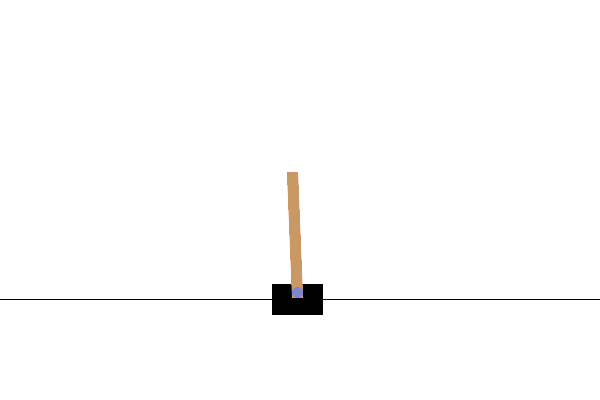

So, let's begin.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

Adding a few utility functions for plotting.

In [2]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x, avg_avg_scores, label=f'{name} agent')
        ax.fill_between(x, upper_std_scores, lower_std_scores, 
                        where=(upper_std_scores > lower_std_scores), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()
    
results_data_dict = {}

# SARSA without a Replay Buffer

Below is the complete SARSA algorithm for the tabular case. We will use a neural network instead of a tabular Q-function.

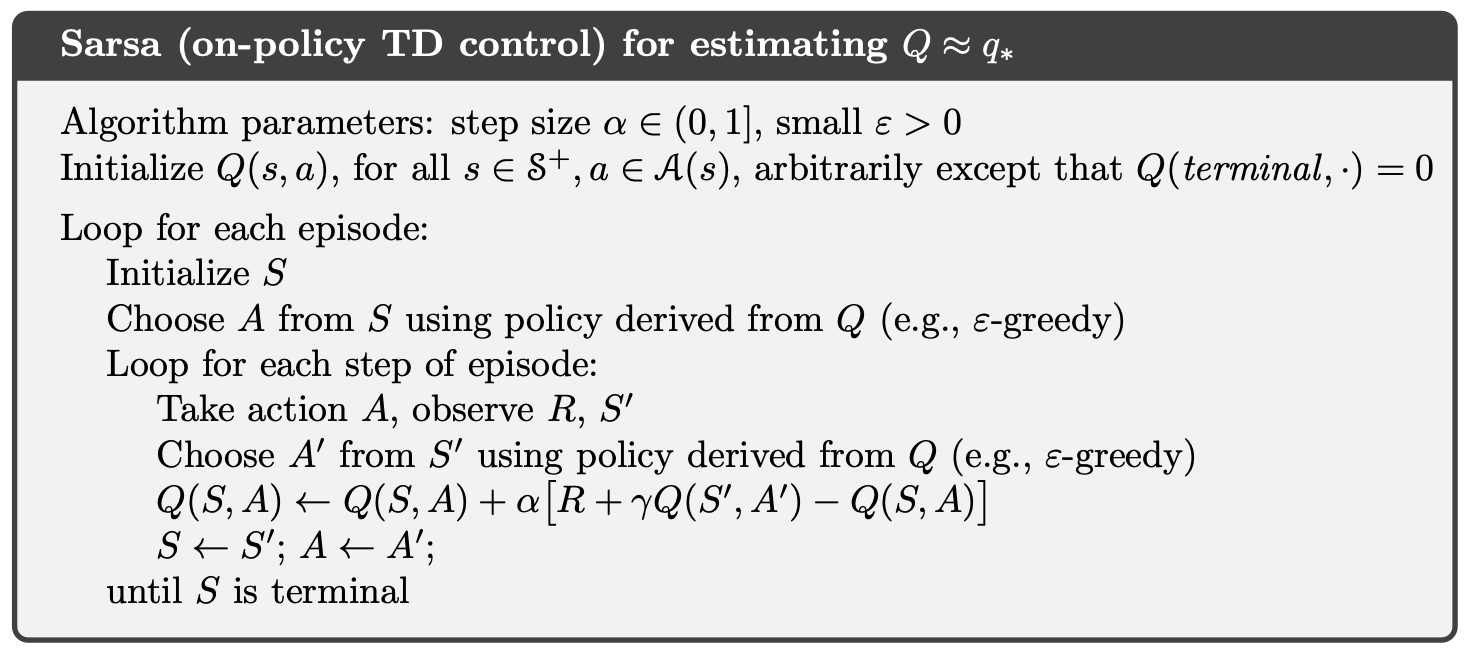

We begin with writing the neural network for the Q-function, which is just a Multi-Layer Perceptron (MLP) with three layers.  

In [3]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)
    
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Then, we write the SARSA agent class, utilizing an $\epsilon$-greedy policy scheme.

In [4]:
class SarsaAgent:
    def __init__(self, observation_dim, action_dim, learning_rate, gamma, epsilon, epsilon_dec, epsilon_min):
        self.gamma = gamma
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        
        # initialize a Q-network
        self.q = QNetwork(observation_dim=observation_dim, action_dim=action_dim, learning_rate=learning_rate)
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        q_values = self.q(observation)
        if evaluate:
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.action_dim)
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()

        action_value = q_values[action].item()
        return action, action_value
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
    
    def learn(self, observation, action, reward, next_observation, next_action, terminated):
        # send observation to device
        observation = T.Tensor(observation).float().to(self.q.device)
        next_observation = T.Tensor(next_observation).float().to(self.q.device)
        
        # compute the values of observations S, S'
        value = self.q(observation)[action].unsqueeze(dim=0)
        next_value = self.q(next_observation)[next_action].unsqueeze(dim=0)
        if terminated:
            next_value = 0. * next_value
        
        # compute the target
        target = T.Tensor([reward]).float().to(self.q.device) + self.gamma * next_value
        
        # train the q network
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()

**Important Remark:** Notice that the Q-Learning algorithm states that for every terminal state, one should set $Q(S_{terminal}, \cdot) = 0$. However, this is only true when the environment actually reaches a terminal state and a terminal reward is returned. In any other case, i.e. the environment is truncated due to a violation of some predefined rule, or because it reaches a maximum number of steps, then the next state $S_{t+1}$ is not a "true" terminal state. Therefore, a terminal reward would not be given, so the q-values of that state should not be set to zero, $Q(S_{t+1}, \cdot) \neq 0$. Setting the q-function to zero in that case would result in a very poor learning process. That is because the network would learn to "classify" many states which are not terminal, as iterminal ones, which is obviously bad. This is probably the reason why *Gymnasium* redefined the old *done* flag (of Gym) into two different *terminated* and *truncated* flags. Therefore, you should only set the q-function to zero when the *terminated* flag equals `True`!


Finally, we run a few experiments on the Cart-Pole environment.

In [5]:
env = gym.make('CartPole-v1')
scores = []
avg_scores = []
std_scores = []

N_EXPERIMENTS = 5
N_EPISODES = 800
MAX_STEPS = 500
GAMMA = 0.99
LR = 5e-4
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n



for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])

    agent = SarsaAgent(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, learning_rate=LR, 
                      gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, epsilon_min=EPSILON_MIN)
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        action, _ = agent.choose_action(observation)
        score = 0
        step = 0
        done = False

        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action, _ = agent.choose_action(next_observation)
            score += reward
            
            # train the agent
            agent.learn(observation, action, reward, next_observation, next_action, terminated)
            
            # set next states to current states
            observation = next_observation
            action = next_action
            step += 1
            
            # check for termination
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f} |' + \
              f' Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

| Experiment:    1 | Episode:    0 | Score: 12.000 | Avg score: 12.000 |
| Experiment:    1 | Episode:    1 | Score: 15.000 | Avg score: 13.500 |
| Experiment:    1 | Episode:    2 | Score: 16.000 | Avg score: 14.330 |
| Experiment:    1 | Episode:    3 | Score: 21.000 | Avg score: 16.000 |
| Experiment:    1 | Episode:    4 | Score: 14.000 | Avg score: 15.600 |
| Experiment:    1 | Episode:    5 | Score: 22.000 | Avg score: 16.670 |
| Experiment:    1 | Episode:    6 | Score: 18.000 | Avg score: 16.860 |
| Experiment:    1 | Episode:    7 | Score: 19.000 | Avg score: 17.120 |
| Experiment:    1 | Episode:    8 | Score: 15.000 | Avg score: 16.890 |
| Experiment:    1 | Episode:    9 | Score: 18.000 | Avg score: 17.000 |
| Experiment:    1 | Episode:   10 | Score: 15.000 | Avg score: 16.820 |
| Experiment:    1 | Episode:   11 | Score: 20.000 | Avg score: 17.080 |
| Experiment:    1 | Episode:   12 | Score: 19.000 | Avg score: 17.230 |
| Experiment:    1 | Episode:   13 | Score: 17.000 

| Experiment:    1 | Episode:  115 | Score: 85.000 | Avg score: 21.410 |
| Experiment:    1 | Episode:  116 | Score: 80.000 | Avg score: 22.110 |
| Experiment:    1 | Episode:  117 | Score: 75.000 | Avg score: 22.750 |
| Experiment:    1 | Episode:  118 | Score: 88.000 | Avg score: 23.520 |
| Experiment:    1 | Episode:  119 | Score: 83.000 | Avg score: 24.250 |
| Experiment:    1 | Episode:  120 | Score: 66.000 | Avg score: 24.810 |
| Experiment:    1 | Episode:  121 | Score: 87.000 | Avg score: 25.580 |
| Experiment:    1 | Episode:  122 | Score: 54.000 | Avg score: 26.020 |
| Experiment:    1 | Episode:  123 | Score: 66.000 | Avg score: 26.590 |
| Experiment:    1 | Episode:  124 | Score: 57.000 | Avg score: 27.070 |
| Experiment:    1 | Episode:  125 | Score: 53.000 | Avg score: 27.510 |
| Experiment:    1 | Episode:  126 | Score: 60.000 | Avg score: 28.020 |
| Experiment:    1 | Episode:  127 | Score: 72.000 | Avg score: 28.650 |
| Experiment:    1 | Episode:  128 | Score: 75.000 

| Experiment:    1 | Episode:  229 | Score: 48.000 | Avg score: 52.660 |
| Experiment:    1 | Episode:  230 | Score: 26.000 | Avg score: 52.440 |
| Experiment:    1 | Episode:  231 | Score: 38.000 | Avg score: 52.310 |
| Experiment:    1 | Episode:  232 | Score: 27.000 | Avg score: 52.020 |
| Experiment:    1 | Episode:  233 | Score: 26.000 | Avg score: 51.760 |
| Experiment:    1 | Episode:  234 | Score: 31.000 | Avg score: 51.510 |
| Experiment:    1 | Episode:  235 | Score: 31.000 | Avg score: 51.360 |
| Experiment:    1 | Episode:  236 | Score: 33.000 | Avg score: 50.930 |
| Experiment:    1 | Episode:  237 | Score: 39.000 | Avg score: 51.050 |
| Experiment:    1 | Episode:  238 | Score: 37.000 | Avg score: 50.660 |
| Experiment:    1 | Episode:  239 | Score: 28.000 | Avg score: 50.400 |
| Experiment:    1 | Episode:  240 | Score: 23.000 | Avg score: 49.310 |
| Experiment:    1 | Episode:  241 | Score: 40.000 | Avg score: 49.260 |
| Experiment:    1 | Episode:  242 | Score: 35.000 

| Experiment:    1 | Episode:  341 | Score: 252.000 | Avg score: 98.610 |
| Experiment:    1 | Episode:  342 | Score: 413.000 | Avg score: 102.390 |
| Experiment:    1 | Episode:  343 | Score: 182.000 | Avg score: 103.880 |
| Experiment:    1 | Episode:  344 | Score: 210.000 | Avg score: 105.610 |
| Experiment:    1 | Episode:  345 | Score: 282.000 | Avg score: 108.060 |
| Experiment:    1 | Episode:  346 | Score: 267.000 | Avg score: 110.320 |
| Experiment:    1 | Episode:  347 | Score: 272.000 | Avg score: 112.680 |
| Experiment:    1 | Episode:  348 | Score: 500.000 | Avg score: 117.300 |
| Experiment:    1 | Episode:  349 | Score: 198.000 | Avg score: 118.860 |
| Experiment:    1 | Episode:  350 | Score: 308.000 | Avg score: 121.550 |
| Experiment:    1 | Episode:  351 | Score: 196.000 | Avg score: 123.260 |
| Experiment:    1 | Episode:  352 | Score: 389.000 | Avg score: 126.860 |
| Experiment:    1 | Episode:  353 | Score: 267.000 | Avg score: 129.140 |
| Experiment:    1 | Episo

| Experiment:    1 | Episode:  456 | Score: 99.000 | Avg score: 112.950 |
| Experiment:    1 | Episode:  457 | Score: 113.000 | Avg score: 113.550 |
| Experiment:    1 | Episode:  458 | Score: 155.000 | Avg score: 114.930 |
| Experiment:    1 | Episode:  459 | Score: 129.000 | Avg score: 116.070 |
| Experiment:    1 | Episode:  460 | Score: 196.000 | Avg score: 116.990 |
| Experiment:    1 | Episode:  461 | Score: 168.000 | Avg score: 115.580 |
| Experiment:    1 | Episode:  462 | Score: 180.000 | Avg score: 113.130 |
| Experiment:    1 | Episode:  463 | Score: 321.000 | Avg score: 112.480 |
| Experiment:    1 | Episode:  464 | Score: 166.000 | Avg score: 110.330 |
| Experiment:    1 | Episode:  465 | Score: 189.000 | Avg score: 109.460 |
| Experiment:    1 | Episode:  466 | Score: 184.000 | Avg score: 109.320 |
| Experiment:    1 | Episode:  467 | Score: 228.000 | Avg score: 109.320 |
| Experiment:    1 | Episode:  468 | Score: 444.000 | Avg score: 110.960 |
| Experiment:    1 | Episo

| Experiment:    1 | Episode:  581 | Score: 10.000 | Avg score: 9.950 |
| Experiment:    1 | Episode:  582 | Score: 8.000 | Avg score: 9.940 |
| Experiment:    1 | Episode:  583 | Score: 10.000 | Avg score: 9.940 |
| Experiment:    1 | Episode:  584 | Score: 10.000 | Avg score: 9.880 |
| Experiment:    1 | Episode:  585 | Score: 8.000 | Avg score: 9.250 |
| Experiment:    1 | Episode:  586 | Score: 10.000 | Avg score: 9.240 |
| Experiment:    1 | Episode:  587 | Score: 8.000 | Avg score: 9.230 |
| Experiment:    1 | Episode:  588 | Score: 9.000 | Avg score: 9.230 |
| Experiment:    1 | Episode:  589 | Score: 10.000 | Avg score: 9.240 |
| Experiment:    1 | Episode:  590 | Score: 10.000 | Avg score: 9.250 |
| Experiment:    1 | Episode:  591 | Score: 10.000 | Avg score: 9.260 |
| Experiment:    1 | Episode:  592 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    1 | Episode:  593 | Score: 10.000 | Avg score: 9.290 |
| Experiment:    1 | Episode:  594 | Score: 9.000 | Avg score: 9.290

| Experiment:    1 | Episode:  717 | Score: 9.000 | Avg score: 36.570 |
| Experiment:    1 | Episode:  718 | Score: 9.000 | Avg score: 35.770 |
| Experiment:    1 | Episode:  719 | Score: 9.000 | Avg score: 34.980 |
| Experiment:    1 | Episode:  720 | Score: 8.000 | Avg score: 34.090 |
| Experiment:    1 | Episode:  721 | Score: 10.000 | Avg score: 33.290 |
| Experiment:    1 | Episode:  722 | Score: 8.000 | Avg score: 32.350 |
| Experiment:    1 | Episode:  723 | Score: 8.000 | Avg score: 31.640 |
| Experiment:    1 | Episode:  724 | Score: 10.000 | Avg score: 30.620 |
| Experiment:    1 | Episode:  725 | Score: 10.000 | Avg score: 29.600 |
| Experiment:    1 | Episode:  726 | Score: 10.000 | Avg score: 28.900 |
| Experiment:    1 | Episode:  727 | Score: 9.000 | Avg score: 28.240 |
| Experiment:    1 | Episode:  728 | Score: 9.000 | Avg score: 27.220 |
| Experiment:    1 | Episode:  729 | Score: 9.000 | Avg score: 26.260 |
| Experiment:    1 | Episode:  730 | Score: 9.000 | Avg scor

| Experiment:    2 | Episode:   53 | Score: 9.000 | Avg score: 10.300 |
| Experiment:    2 | Episode:   54 | Score: 10.000 | Avg score: 10.290 |
| Experiment:    2 | Episode:   55 | Score: 9.000 | Avg score: 10.270 |
| Experiment:    2 | Episode:   56 | Score: 9.000 | Avg score: 10.250 |
| Experiment:    2 | Episode:   57 | Score: 8.000 | Avg score: 10.210 |
| Experiment:    2 | Episode:   58 | Score: 8.000 | Avg score: 10.170 |
| Experiment:    2 | Episode:   59 | Score: 9.000 | Avg score: 10.150 |
| Experiment:    2 | Episode:   60 | Score: 10.000 | Avg score: 10.150 |
| Experiment:    2 | Episode:   61 | Score: 11.000 | Avg score: 10.160 |
| Experiment:    2 | Episode:   62 | Score: 10.000 | Avg score: 10.160 |
| Experiment:    2 | Episode:   63 | Score: 10.000 | Avg score: 10.160 |
| Experiment:    2 | Episode:   64 | Score: 9.000 | Avg score: 10.140 |
| Experiment:    2 | Episode:   65 | Score: 8.000 | Avg score: 10.110 |
| Experiment:    2 | Episode:   66 | Score: 9.000 | Avg sco

| Experiment:    2 | Episode:  170 | Score: 156.000 | Avg score: 23.850 |
| Experiment:    2 | Episode:  171 | Score: 83.000 | Avg score: 24.500 |
| Experiment:    2 | Episode:  172 | Score: 92.000 | Avg score: 25.000 |
| Experiment:    2 | Episode:  173 | Score: 135.000 | Avg score: 26.190 |
| Experiment:    2 | Episode:  174 | Score: 69.000 | Avg score: 26.790 |
| Experiment:    2 | Episode:  175 | Score: 67.000 | Avg score: 27.370 |
| Experiment:    2 | Episode:  176 | Score: 54.000 | Avg score: 27.820 |
| Experiment:    2 | Episode:  177 | Score: 92.000 | Avg score: 28.650 |
| Experiment:    2 | Episode:  178 | Score: 97.000 | Avg score: 29.530 |
| Experiment:    2 | Episode:  179 | Score: 157.000 | Avg score: 31.010 |
| Experiment:    2 | Episode:  180 | Score: 68.000 | Avg score: 31.590 |
| Experiment:    2 | Episode:  181 | Score: 338.000 | Avg score: 34.890 |
| Experiment:    2 | Episode:  182 | Score: 67.000 | Avg score: 35.450 |
| Experiment:    2 | Episode:  183 | Score: 116

| Experiment:    2 | Episode:  284 | Score: 24.000 | Avg score: 49.410 |
| Experiment:    2 | Episode:  285 | Score: 29.000 | Avg score: 49.110 |
| Experiment:    2 | Episode:  286 | Score: 30.000 | Avg score: 48.740 |
| Experiment:    2 | Episode:  287 | Score: 36.000 | Avg score: 47.750 |
| Experiment:    2 | Episode:  288 | Score: 32.000 | Avg score: 43.760 |
| Experiment:    2 | Episode:  289 | Score: 31.000 | Avg score: 42.880 |
| Experiment:    2 | Episode:  290 | Score: 30.000 | Avg score: 42.760 |
| Experiment:    2 | Episode:  291 | Score: 34.000 | Avg score: 42.020 |
| Experiment:    2 | Episode:  292 | Score: 29.000 | Avg score: 41.730 |
| Experiment:    2 | Episode:  293 | Score: 29.000 | Avg score: 41.360 |
| Experiment:    2 | Episode:  294 | Score: 28.000 | Avg score: 40.780 |
| Experiment:    2 | Episode:  295 | Score: 38.000 | Avg score: 40.620 |
| Experiment:    2 | Episode:  296 | Score: 29.000 | Avg score: 40.310 |
| Experiment:    2 | Episode:  297 | Score: 27.000 

| Experiment:    2 | Episode:  397 | Score: 34.000 | Avg score: 35.420 |
| Experiment:    2 | Episode:  398 | Score: 34.000 | Avg score: 35.360 |
| Experiment:    2 | Episode:  399 | Score: 34.000 | Avg score: 35.360 |
| Experiment:    2 | Episode:  400 | Score: 31.000 | Avg score: 35.340 |
| Experiment:    2 | Episode:  401 | Score: 33.000 | Avg score: 35.000 |
| Experiment:    2 | Episode:  402 | Score: 35.000 | Avg score: 34.990 |
| Experiment:    2 | Episode:  403 | Score: 37.000 | Avg score: 35.050 |
| Experiment:    2 | Episode:  404 | Score: 38.000 | Avg score: 35.040 |
| Experiment:    2 | Episode:  405 | Score: 43.000 | Avg score: 35.080 |
| Experiment:    2 | Episode:  406 | Score: 47.000 | Avg score: 35.140 |
| Experiment:    2 | Episode:  407 | Score: 32.000 | Avg score: 35.140 |
| Experiment:    2 | Episode:  408 | Score: 29.000 | Avg score: 35.130 |
| Experiment:    2 | Episode:  409 | Score: 38.000 | Avg score: 34.920 |
| Experiment:    2 | Episode:  410 | Score: 43.000 

| Experiment:    2 | Episode:  510 | Score: 262.000 | Avg score: 69.890 |
| Experiment:    2 | Episode:  511 | Score: 105.000 | Avg score: 70.530 |
| Experiment:    2 | Episode:  512 | Score: 207.000 | Avg score: 72.280 |
| Experiment:    2 | Episode:  513 | Score: 210.000 | Avg score: 73.970 |
| Experiment:    2 | Episode:  514 | Score: 85.000 | Avg score: 74.510 |
| Experiment:    2 | Episode:  515 | Score: 186.000 | Avg score: 76.000 |
| Experiment:    2 | Episode:  516 | Score: 219.000 | Avg score: 77.720 |
| Experiment:    2 | Episode:  517 | Score: 154.000 | Avg score: 78.890 |
| Experiment:    2 | Episode:  518 | Score: 122.000 | Avg score: 79.700 |
| Experiment:    2 | Episode:  519 | Score: 137.000 | Avg score: 80.730 |
| Experiment:    2 | Episode:  520 | Score: 170.000 | Avg score: 82.130 |
| Experiment:    2 | Episode:  521 | Score: 192.000 | Avg score: 83.600 |
| Experiment:    2 | Episode:  522 | Score: 14.000 | Avg score: 83.450 |
| Experiment:    2 | Episode:  523 | Sco

| Experiment:    2 | Episode:  656 | Score: 9.000 | Avg score: 9.440 |
| Experiment:    2 | Episode:  657 | Score: 8.000 | Avg score: 9.420 |
| Experiment:    2 | Episode:  658 | Score: 10.000 | Avg score: 9.430 |
| Experiment:    2 | Episode:  659 | Score: 10.000 | Avg score: 9.430 |
| Experiment:    2 | Episode:  660 | Score: 10.000 | Avg score: 9.430 |
| Experiment:    2 | Episode:  661 | Score: 8.000 | Avg score: 9.410 |
| Experiment:    2 | Episode:  662 | Score: 9.000 | Avg score: 9.410 |
| Experiment:    2 | Episode:  663 | Score: 8.000 | Avg score: 9.400 |
| Experiment:    2 | Episode:  664 | Score: 10.000 | Avg score: 9.400 |
| Experiment:    2 | Episode:  665 | Score: 8.000 | Avg score: 9.400 |
| Experiment:    2 | Episode:  666 | Score: 9.000 | Avg score: 9.390 |
| Experiment:    2 | Episode:  667 | Score: 10.000 | Avg score: 9.390 |
| Experiment:    2 | Episode:  668 | Score: 10.000 | Avg score: 9.390 |
| Experiment:    2 | Episode:  669 | Score: 9.000 | Avg score: 9.380 |


| Experiment:    2 | Episode:  768 | Score: 65.000 | Avg score: 136.590 |
| Experiment:    2 | Episode:  769 | Score: 91.000 | Avg score: 137.410 |
| Experiment:    2 | Episode:  770 | Score: 47.000 | Avg score: 137.800 |
| Experiment:    2 | Episode:  771 | Score: 62.000 | Avg score: 138.320 |
| Experiment:    2 | Episode:  772 | Score: 40.000 | Avg score: 138.620 |
| Experiment:    2 | Episode:  773 | Score: 36.000 | Avg score: 138.890 |
| Experiment:    2 | Episode:  774 | Score: 78.000 | Avg score: 139.570 |
| Experiment:    2 | Episode:  775 | Score: 45.000 | Avg score: 139.930 |
| Experiment:    2 | Episode:  776 | Score: 52.000 | Avg score: 140.360 |
| Experiment:    2 | Episode:  777 | Score: 65.000 | Avg score: 140.920 |
| Experiment:    2 | Episode:  778 | Score: 57.000 | Avg score: 141.390 |
| Experiment:    2 | Episode:  779 | Score: 65.000 | Avg score: 141.940 |
| Experiment:    2 | Episode:  780 | Score: 62.000 | Avg score: 142.460 |
| Experiment:    2 | Episode:  781 | S

| Experiment:    3 | Episode:   90 | Score: 54.000 | Avg score: 13.080 |
| Experiment:    3 | Episode:   91 | Score: 90.000 | Avg score: 13.910 |
| Experiment:    3 | Episode:   92 | Score: 88.000 | Avg score: 14.710 |
| Experiment:    3 | Episode:   93 | Score: 50.000 | Avg score: 15.090 |
| Experiment:    3 | Episode:   94 | Score: 47.000 | Avg score: 15.420 |
| Experiment:    3 | Episode:   95 | Score: 80.000 | Avg score: 16.090 |
| Experiment:    3 | Episode:   96 | Score: 95.000 | Avg score: 16.910 |
| Experiment:    3 | Episode:   97 | Score: 44.000 | Avg score: 17.180 |
| Experiment:    3 | Episode:   98 | Score: 70.000 | Avg score: 17.720 |
| Experiment:    3 | Episode:   99 | Score: 51.000 | Avg score: 18.050 |
| Experiment:    3 | Episode:  100 | Score: 77.000 | Avg score: 18.620 |
| Experiment:    3 | Episode:  101 | Score: 63.000 | Avg score: 19.120 |
| Experiment:    3 | Episode:  102 | Score: 53.000 | Avg score: 19.390 |
| Experiment:    3 | Episode:  103 | Score: 65.000 

| Experiment:    3 | Episode:  208 | Score: 28.000 | Avg score: 61.930 |
| Experiment:    3 | Episode:  209 | Score: 45.000 | Avg score: 61.800 |
| Experiment:    3 | Episode:  210 | Score: 197.000 | Avg score: 63.320 |
| Experiment:    3 | Episode:  211 | Score: 199.000 | Avg score: 64.530 |
| Experiment:    3 | Episode:  212 | Score: 152.000 | Avg score: 65.670 |
| Experiment:    3 | Episode:  213 | Score: 14.000 | Avg score: 64.800 |
| Experiment:    3 | Episode:  214 | Score: 20.000 | Avg score: 61.680 |
| Experiment:    3 | Episode:  215 | Score: 158.000 | Avg score: 62.750 |
| Experiment:    3 | Episode:  216 | Score: 29.000 | Avg score: 62.480 |
| Experiment:    3 | Episode:  217 | Score: 18.000 | Avg score: 61.960 |
| Experiment:    3 | Episode:  218 | Score: 119.000 | Avg score: 62.530 |
| Experiment:    3 | Episode:  219 | Score: 28.000 | Avg score: 62.380 |
| Experiment:    3 | Episode:  220 | Score: 239.000 | Avg score: 63.460 |
| Experiment:    3 | Episode:  221 | Score: 1

| Experiment:    3 | Episode:  341 | Score: 10.000 | Avg score: 9.300 |
| Experiment:    3 | Episode:  342 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  343 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:  344 | Score: 9.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:  345 | Score: 9.000 | Avg score: 9.310 |
| Experiment:    3 | Episode:  346 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  347 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:  348 | Score: 8.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:  349 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  350 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  351 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  352 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:  353 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:  354 | Score: 9.000 | Avg score: 9.320 |

| Experiment:    3 | Episode:  477 | Score: 10.000 | Avg score: 10.100 |
| Experiment:    3 | Episode:  478 | Score: 8.000 | Avg score: 10.080 |
| Experiment:    3 | Episode:  479 | Score: 10.000 | Avg score: 10.080 |
| Experiment:    3 | Episode:  480 | Score: 9.000 | Avg score: 10.080 |
| Experiment:    3 | Episode:  481 | Score: 10.000 | Avg score: 10.090 |
| Experiment:    3 | Episode:  482 | Score: 10.000 | Avg score: 10.100 |
| Experiment:    3 | Episode:  483 | Score: 8.000 | Avg score: 10.080 |
| Experiment:    3 | Episode:  484 | Score: 10.000 | Avg score: 10.100 |
| Experiment:    3 | Episode:  485 | Score: 10.000 | Avg score: 10.110 |
| Experiment:    3 | Episode:  486 | Score: 10.000 | Avg score: 10.110 |
| Experiment:    3 | Episode:  487 | Score: 9.000 | Avg score: 10.100 |
| Experiment:    3 | Episode:  488 | Score: 9.000 | Avg score: 10.090 |
| Experiment:    3 | Episode:  489 | Score: 9.000 | Avg score: 10.100 |
| Experiment:    3 | Episode:  490 | Score: 9.000 | Avg s

| Experiment:    3 | Episode:  616 | Score: 9.000 | Avg score: 21.160 |
| Experiment:    3 | Episode:  617 | Score: 8.000 | Avg score: 18.690 |
| Experiment:    3 | Episode:  618 | Score: 9.000 | Avg score: 16.010 |
| Experiment:    3 | Episode:  619 | Score: 11.000 | Avg score: 14.210 |
| Experiment:    3 | Episode:  620 | Score: 9.000 | Avg score: 12.450 |
| Experiment:    3 | Episode:  621 | Score: 8.000 | Avg score: 10.390 |
| Experiment:    3 | Episode:  622 | Score: 9.000 | Avg score: 10.400 |
| Experiment:    3 | Episode:  623 | Score: 10.000 | Avg score: 10.410 |
| Experiment:    3 | Episode:  624 | Score: 10.000 | Avg score: 10.410 |
| Experiment:    3 | Episode:  625 | Score: 10.000 | Avg score: 10.410 |
| Experiment:    3 | Episode:  626 | Score: 10.000 | Avg score: 10.420 |
| Experiment:    3 | Episode:  627 | Score: 10.000 | Avg score: 10.430 |
| Experiment:    3 | Episode:  628 | Score: 9.000 | Avg score: 10.430 |
| Experiment:    3 | Episode:  629 | Score: 8.000 | Avg sc

| Experiment:    3 | Episode:  729 | Score: 296.000 | Avg score: 120.470 |
| Experiment:    3 | Episode:  730 | Score: 116.000 | Avg score: 121.540 |
| Experiment:    3 | Episode:  731 | Score: 93.000 | Avg score: 122.370 |
| Experiment:    3 | Episode:  732 | Score: 119.000 | Avg score: 123.460 |
| Experiment:    3 | Episode:  733 | Score: 114.000 | Avg score: 124.510 |
| Experiment:    3 | Episode:  734 | Score: 128.000 | Avg score: 125.700 |
| Experiment:    3 | Episode:  735 | Score: 85.000 | Avg score: 126.470 |
| Experiment:    3 | Episode:  736 | Score: 73.000 | Avg score: 127.090 |
| Experiment:    3 | Episode:  737 | Score: 67.000 | Avg score: 127.660 |
| Experiment:    3 | Episode:  738 | Score: 78.000 | Avg score: 128.350 |
| Experiment:    3 | Episode:  739 | Score: 114.000 | Avg score: 129.400 |
| Experiment:    3 | Episode:  740 | Score: 60.000 | Avg score: 129.910 |
| Experiment:    3 | Episode:  741 | Score: 97.000 | Avg score: 130.790 |
| Experiment:    3 | Episode:  7

| Experiment:    4 | Episode:   49 | Score: 37.000 | Avg score: 14.400 |
| Experiment:    4 | Episode:   50 | Score: 55.000 | Avg score: 15.200 |
| Experiment:    4 | Episode:   51 | Score: 33.000 | Avg score: 15.540 |
| Experiment:    4 | Episode:   52 | Score: 30.000 | Avg score: 15.810 |
| Experiment:    4 | Episode:   53 | Score: 34.000 | Avg score: 16.150 |
| Experiment:    4 | Episode:   54 | Score: 38.000 | Avg score: 16.550 |
| Experiment:    4 | Episode:   55 | Score: 42.000 | Avg score: 17.000 |
| Experiment:    4 | Episode:   56 | Score: 32.000 | Avg score: 17.260 |
| Experiment:    4 | Episode:   57 | Score: 56.000 | Avg score: 17.930 |
| Experiment:    4 | Episode:   58 | Score: 49.000 | Avg score: 18.460 |
| Experiment:    4 | Episode:   59 | Score: 29.000 | Avg score: 18.630 |
| Experiment:    4 | Episode:   60 | Score: 40.000 | Avg score: 18.980 |
| Experiment:    4 | Episode:   61 | Score: 58.000 | Avg score: 19.610 |
| Experiment:    4 | Episode:   62 | Score: 27.000 

| Experiment:    4 | Episode:  189 | Score: 10.000 | Avg score: 20.620 |
| Experiment:    4 | Episode:  190 | Score: 9.000 | Avg score: 20.310 |
| Experiment:    4 | Episode:  191 | Score: 9.000 | Avg score: 20.070 |
| Experiment:    4 | Episode:  192 | Score: 10.000 | Avg score: 19.840 |
| Experiment:    4 | Episode:  193 | Score: 9.000 | Avg score: 19.460 |
| Experiment:    4 | Episode:  194 | Score: 10.000 | Avg score: 19.170 |
| Experiment:    4 | Episode:  195 | Score: 9.000 | Avg score: 18.850 |
| Experiment:    4 | Episode:  196 | Score: 10.000 | Avg score: 18.580 |
| Experiment:    4 | Episode:  197 | Score: 9.000 | Avg score: 18.380 |
| Experiment:    4 | Episode:  198 | Score: 10.000 | Avg score: 18.010 |
| Experiment:    4 | Episode:  199 | Score: 10.000 | Avg score: 17.670 |
| Experiment:    4 | Episode:  200 | Score: 10.000 | Avg score: 17.420 |
| Experiment:    4 | Episode:  201 | Score: 11.000 | Avg score: 17.030 |
| Experiment:    4 | Episode:  202 | Score: 10.000 | Avg

| Experiment:    4 | Episode:  333 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  334 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  335 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  336 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  337 | Score: 9.000 | Avg score: 9.310 |
| Experiment:    4 | Episode:  338 | Score: 10.000 | Avg score: 9.310 |
| Experiment:    4 | Episode:  339 | Score: 8.000 | Avg score: 9.300 |
| Experiment:    4 | Episode:  340 | Score: 10.000 | Avg score: 9.310 |
| Experiment:    4 | Episode:  341 | Score: 9.000 | Avg score: 9.300 |
| Experiment:    4 | Episode:  342 | Score: 11.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  343 | Score: 8.000 | Avg score: 9.310 |
| Experiment:    4 | Episode:  344 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  345 | Score: 9.000 | Avg score: 9.310 |
| Experiment:    4 | Episode:  346 | Score: 10.000 | Avg score: 9.310 |
|

| Experiment:    4 | Episode:  476 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    4 | Episode:  477 | Score: 8.000 | Avg score: 9.350 |
| Experiment:    4 | Episode:  478 | Score: 8.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  479 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  480 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  481 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  482 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  483 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  484 | Score: 9.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  485 | Score: 10.000 | Avg score: 9.350 |
| Experiment:    4 | Episode:  486 | Score: 8.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  487 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  488 | Score: 11.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  489 | Score: 9.000 | Avg score: 9.340 

| Experiment:    4 | Episode:  617 | Score: 8.000 | Avg score: 9.420 |
| Experiment:    4 | Episode:  618 | Score: 10.000 | Avg score: 9.430 |
| Experiment:    4 | Episode:  619 | Score: 9.000 | Avg score: 9.420 |
| Experiment:    4 | Episode:  620 | Score: 9.000 | Avg score: 9.410 |
| Experiment:    4 | Episode:  621 | Score: 8.000 | Avg score: 9.410 |
| Experiment:    4 | Episode:  622 | Score: 9.000 | Avg score: 9.410 |
| Experiment:    4 | Episode:  623 | Score: 9.000 | Avg score: 9.410 |
| Experiment:    4 | Episode:  624 | Score: 8.000 | Avg score: 9.400 |
| Experiment:    4 | Episode:  625 | Score: 10.000 | Avg score: 9.400 |
| Experiment:    4 | Episode:  626 | Score: 9.000 | Avg score: 9.410 |
| Experiment:    4 | Episode:  627 | Score: 10.000 | Avg score: 9.430 |
| Experiment:    4 | Episode:  628 | Score: 8.000 | Avg score: 9.420 |
| Experiment:    4 | Episode:  629 | Score: 9.000 | Avg score: 9.420 |
| Experiment:    4 | Episode:  630 | Score: 8.000 | Avg score: 9.420 |
| E

| Experiment:    4 | Episode:  761 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    4 | Episode:  762 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    4 | Episode:  763 | Score: 8.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  764 | Score: 8.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  765 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  766 | Score: 11.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  767 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  768 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    4 | Episode:  769 | Score: 9.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  770 | Score: 8.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  771 | Score: 10.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  772 | Score: 10.000 | Avg score: 9.330 |
| Experiment:    4 | Episode:  773 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    4 | Episode:  774 | Score: 10.000 | Avg score: 9.320 |

| Experiment:    5 | Episode:   93 | Score: 10.000 | Avg score: 10.510 |
| Experiment:    5 | Episode:   94 | Score: 8.000 | Avg score: 10.480 |
| Experiment:    5 | Episode:   95 | Score: 9.000 | Avg score: 10.470 |
| Experiment:    5 | Episode:   96 | Score: 9.000 | Avg score: 10.450 |
| Experiment:    5 | Episode:   97 | Score: 9.000 | Avg score: 10.440 |
| Experiment:    5 | Episode:   98 | Score: 10.000 | Avg score: 10.430 |
| Experiment:    5 | Episode:   99 | Score: 9.000 | Avg score: 10.420 |
| Experiment:    5 | Episode:  100 | Score: 9.000 | Avg score: 10.240 |
| Experiment:    5 | Episode:  101 | Score: 10.000 | Avg score: 10.040 |
| Experiment:    5 | Episode:  102 | Score: 9.000 | Avg score: 9.880 |
| Experiment:    5 | Episode:  103 | Score: 10.000 | Avg score: 9.420 |
| Experiment:    5 | Episode:  104 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    5 | Episode:  105 | Score: 10.000 | Avg score: 9.370 |
| Experiment:    5 | Episode:  106 | Score: 10.000 | Avg score:

| Experiment:    5 | Episode:  208 | Score: 29.000 | Avg score: 42.340 |
| Experiment:    5 | Episode:  209 | Score: 58.000 | Avg score: 42.820 |
| Experiment:    5 | Episode:  210 | Score: 31.000 | Avg score: 43.040 |
| Experiment:    5 | Episode:  211 | Score: 50.000 | Avg score: 43.440 |
| Experiment:    5 | Episode:  212 | Score: 45.000 | Avg score: 43.790 |
| Experiment:    5 | Episode:  213 | Score: 29.000 | Avg score: 43.990 |
| Experiment:    5 | Episode:  214 | Score: 34.000 | Avg score: 44.240 |
| Experiment:    5 | Episode:  215 | Score: 45.000 | Avg score: 44.590 |
| Experiment:    5 | Episode:  216 | Score: 39.000 | Avg score: 44.890 |
| Experiment:    5 | Episode:  217 | Score: 49.000 | Avg score: 45.300 |
| Experiment:    5 | Episode:  218 | Score: 28.000 | Avg score: 45.480 |
| Experiment:    5 | Episode:  219 | Score: 44.000 | Avg score: 45.830 |
| Experiment:    5 | Episode:  220 | Score: 27.000 | Avg score: 46.000 |
| Experiment:    5 | Episode:  221 | Score: 39.000 

| Experiment:    5 | Episode:  341 | Score: 10.000 | Avg score: 9.340 |
| Experiment:    5 | Episode:  342 | Score: 10.000 | Avg score: 9.250 |
| Experiment:    5 | Episode:  343 | Score: 10.000 | Avg score: 9.250 |
| Experiment:    5 | Episode:  344 | Score: 10.000 | Avg score: 9.260 |
| Experiment:    5 | Episode:  345 | Score: 9.000 | Avg score: 9.250 |
| Experiment:    5 | Episode:  346 | Score: 10.000 | Avg score: 9.250 |
| Experiment:    5 | Episode:  347 | Score: 8.000 | Avg score: 9.220 |
| Experiment:    5 | Episode:  348 | Score: 9.000 | Avg score: 9.230 |
| Experiment:    5 | Episode:  349 | Score: 9.000 | Avg score: 9.240 |
| Experiment:    5 | Episode:  350 | Score: 9.000 | Avg score: 9.230 |
| Experiment:    5 | Episode:  351 | Score: 9.000 | Avg score: 9.220 |
| Experiment:    5 | Episode:  352 | Score: 10.000 | Avg score: 9.230 |
| Experiment:    5 | Episode:  353 | Score: 10.000 | Avg score: 9.250 |
| Experiment:    5 | Episode:  354 | Score: 10.000 | Avg score: 9.250 

| Experiment:    5 | Episode:  486 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  487 | Score: 9.000 | Avg score: 9.260 |
| Experiment:    5 | Episode:  488 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  489 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  490 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  491 | Score: 9.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  492 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  493 | Score: 8.000 | Avg score: 9.260 |
| Experiment:    5 | Episode:  494 | Score: 10.000 | Avg score: 9.270 |
| Experiment:    5 | Episode:  495 | Score: 9.000 | Avg score: 9.260 |
| Experiment:    5 | Episode:  496 | Score: 10.000 | Avg score: 9.280 |
| Experiment:    5 | Episode:  497 | Score: 10.000 | Avg score: 9.290 |
| Experiment:    5 | Episode:  498 | Score: 10.000 | Avg score: 9.290 |
| Experiment:    5 | Episode:  499 | Score: 10.000 | Avg score: 9.29

| Experiment:    5 | Episode:  626 | Score: 93.000 | Avg score: 10.270 |
| Experiment:    5 | Episode:  627 | Score: 12.000 | Avg score: 10.290 |
| Experiment:    5 | Episode:  628 | Score: 10.000 | Avg score: 10.310 |
| Experiment:    5 | Episode:  629 | Score: 168.000 | Avg score: 11.900 |
| Experiment:    5 | Episode:  630 | Score: 13.000 | Avg score: 11.940 |
| Experiment:    5 | Episode:  631 | Score: 36.000 | Avg score: 12.200 |
| Experiment:    5 | Episode:  632 | Score: 47.000 | Avg score: 12.590 |
| Experiment:    5 | Episode:  633 | Score: 66.000 | Avg score: 13.160 |
| Experiment:    5 | Episode:  634 | Score: 32.000 | Avg score: 13.390 |
| Experiment:    5 | Episode:  635 | Score: 34.000 | Avg score: 13.630 |
| Experiment:    5 | Episode:  636 | Score: 29.000 | Avg score: 13.830 |
| Experiment:    5 | Episode:  637 | Score: 62.000 | Avg score: 14.350 |
| Experiment:    5 | Episode:  638 | Score: 53.000 | Avg score: 14.790 |
| Experiment:    5 | Episode:  639 | Score: 50.000

| Experiment:    5 | Episode:  739 | Score: 65.000 | Avg score: 72.370 |
| Experiment:    5 | Episode:  740 | Score: 49.000 | Avg score: 72.150 |
| Experiment:    5 | Episode:  741 | Score: 119.000 | Avg score: 72.600 |
| Experiment:    5 | Episode:  742 | Score: 70.000 | Avg score: 72.840 |
| Experiment:    5 | Episode:  743 | Score: 123.000 | Avg score: 73.580 |
| Experiment:    5 | Episode:  744 | Score: 131.000 | Avg score: 74.120 |
| Experiment:    5 | Episode:  745 | Score: 52.000 | Avg score: 74.080 |
| Experiment:    5 | Episode:  746 | Score: 81.000 | Avg score: 74.390 |
| Experiment:    5 | Episode:  747 | Score: 220.000 | Avg score: 76.150 |
| Experiment:    5 | Episode:  748 | Score: 68.000 | Avg score: 76.350 |
| Experiment:    5 | Episode:  749 | Score: 51.000 | Avg score: 76.410 |
| Experiment:    5 | Episode:  750 | Score: 57.000 | Avg score: 76.060 |
| Experiment:    5 | Episode:  751 | Score: 70.000 | Avg score: 75.960 |
| Experiment:    5 | Episode:  752 | Score: 107

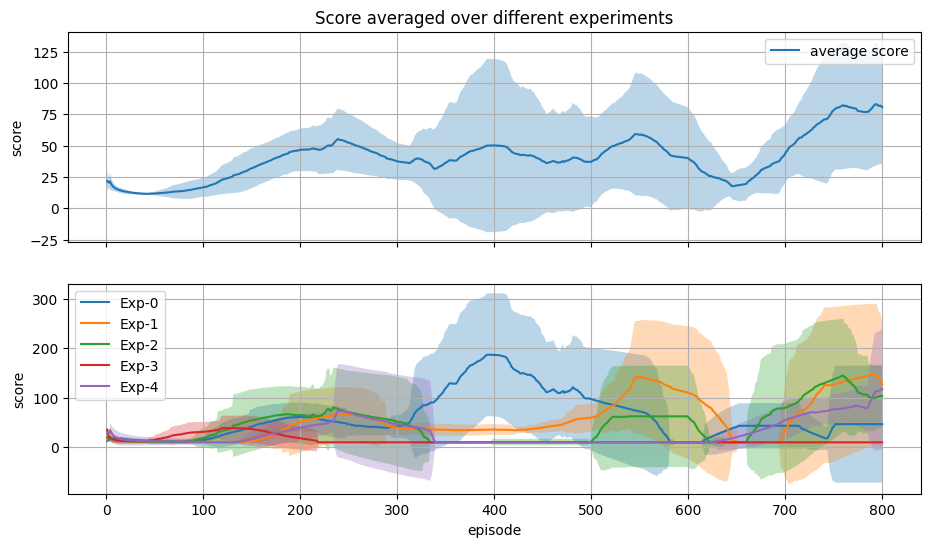

In [6]:
results_data_dict["SARSA"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

The Cart-Pole environment is considered solved when reaching 500 points. Therefore, we see that the SARSA algorithm is having a hard time to complete the environment, and also has a lot of variance in terms of learning. On the other hand, we did not put a lot of effort in tuning the model's hyperparameters, which could also explain the mediocre performance.

## Adding a Replay Buffer

Next, we add a replay buffer to the SARSA algorithm. Although training with PyTorch, which uses Tensor objects, it is simpler and more convenient to code the replay-buffer in Numpy.

In [7]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.ptr = 0
        self.is_full = False
        
        self.observations = None
        self.actions = None
        self.rewards = None
        self.next_observations = None
        self.next_actions = None
        self.terminates = None
        
    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, 1), dtype=np.float32)
        self.next_observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.next_actions = np.zeros((self.memory_size, 1), dtype=int)
        self.terminates = np.zeros((self.memory_size, 1), dtype=bool)
        self.ptr = 0
    
    def store_transition(self, observation, action, reward, next_observation, next_action, terminated):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_observations[self.ptr] = next_observation
        self.next_actions[self.ptr] = next_action
        self.terminates[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr==0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")
    
    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return (self.observations[samples], self.actions[samples], self.rewards[samples], 
                self.next_observations[samples], self.next_actions[samples], self.terminates[samples])
    

Next, we make a few little adjustments to the original SARSA agent, for it to be compatible with the replay-buffer component. We add a `store_transition` and `load_batch` functions, that saves the experience into the replay-buffer's memory and loads a batch of transitions from the replay-buffer for training the Q-network respectively.

In [8]:
class SarsaAgentWithBuffer:
    def __init__(self, observation_dim, action_dim, n_actions, learning_rate, gamma, epsilon, epsilon_dec, 
                 epsilon_min, memory_size, ):
        self.gamma = gamma
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.training_step = 0
        
        # initialize replay buffer
        self.replay_buffer = ReplayBuffer(memory_size=memory_size, observation_dim=observation_dim)
        self.replay_buffer.reset()
        
        # initialize a Q-network
        self.q = QNetwork(observation_dim=observation_dim, action_dim=n_actions, learning_rate=learning_rate)
        
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        q_values = self.q(observation)
        if evaluate:
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.n_actions)
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()

        action_value = q_values[action].item()
        return action, action_value
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
        
    def store_transition(self, observation, action, reward, next_observation, next_action, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, next_action, terminated)
    
    def load_batch(self, batch_size=1):
        # sample new batch from buffer
        observation, action, reward, next_observation, next_action, terminated = self.replay_buffer.load_transition(
            batch_size=batch_size)
        
        # send batch to device
        observation = T.Tensor(observation).float().to(self.q.device)
        action = T.Tensor(action).int().view(-1).to(self.q.device)
        reward = T.Tensor(reward).float().view(-1).to(self.q.device)
        next_observation = T.Tensor(next_observation).float().to(self.q.device)
        next_action = T.Tensor(next_action).int().view(-1).to(self.q.device)
        terminated = T.Tensor(terminated).bool().view(-1).to(self.q.device)
        return observation, action, reward, next_observation, next_action, terminated
    
    def learn(self, batch_size=1):
        self.training_step += 1
        if self.training_step < batch_size:
            return
        
        # send observation to device
        observation, action, reward, next_observation, next_action, terminated = self.load_batch(batch_size=batch_size)
        
        # compute the values of observations S, S'
        indices = np.arange(batch_size)
        value = self.q(observation)[indices, action]
        next_value = self.q(next_observation)[indices, next_action]
        next_value[terminated] = 0.  # setting the terminal states values to zero by hand
        
        # compute the target
        target = reward + self.gamma * next_value
        
        # train the q network
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()

Finally, we can run a few experiments. We use similar values for the hyperparameters as in the original SARSA experiment, just to have some common ground for comparison. Also, we use a `BATCH_SIZE` of $1$, so the agent with the replay-buffer end up with approximately the same number of learning samples (this is an approximation because episodes are initialized randomly, so different trajectories will have different lengths).

In [11]:
env = gym.make('CartPole-v1')
scores = []
avg_scores = []
std_scores = []

N_EXPERIMENTS = 5
N_EPISODES = 800
MAX_STEPS = 500
GAMMA = 0.99
LR = 5e-4
MEMORY_SIZE = 100000
BATCH_SIZE = 1
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1



for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])

    agent = SarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS,
                                 learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                                 epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        action, _ = agent.choose_action(observation)
        score = 0
        step = 0
        done = False

        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action, _ = agent.choose_action(next_observation)
            score += reward
            
            # store transition in buffer
            agent.store_transition(observation, action, reward, next_observation, next_action, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            action = next_action
            step += 1
            
            # check for termination
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f} |' + 
              f' Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: 14.000 | Avg score: 14.000 |
| Experiment:    1 | Episode:    1 | Score: 13.000 | Avg score: 13.500 |
| Experiment:    1 | Episode:    2 | Score: 16.000 | Avg score: 14.330 |
| Experiment:    1 | Episode:    3 | Score: 33.000 | Avg score: 19.000 |
| Experiment:    1 | Episode:    4 | Score: 10.000 | Avg score: 17.200 |
| Experiment:    1 | Episode:    5 | Score: 10.000 | Avg score: 16.000 |
| Experiment:    1 | Episode:    6 | Score: 9.000 | Avg score: 15.000 |
| Experiment:    1 | Episode:    7 | Score: 22.000 | Avg score: 15.880 |
| Experiment:    1 | Episode:    8 | Score: 10.000 | Avg score: 15.220 |
| Experiment:    1 | Episode:    9 | Score: 14.000 | Avg score: 15.100 |
| Experiment:    1 | Episode:   10 | Score: 12.000 | Avg score: 14.820 |
| Experiment:    1 | Episode:   11 | Score: 10.000 | Avg score: 14.420 |
| Experiment:    1 | Episode:   12 | Score: 10.000 | Avg score: 14.080 |
| Experiment:    1 | Episode:   13 |

| Experiment:    1 | Episode:  115 | Score: 110.000 | Avg score: 21.010 |
| Experiment:    1 | Episode:  116 | Score: 54.000 | Avg score: 21.440 |
| Experiment:    1 | Episode:  117 | Score: 71.000 | Avg score: 21.950 |
| Experiment:    1 | Episode:  118 | Score: 16.000 | Avg score: 21.850 |
| Experiment:    1 | Episode:  119 | Score: 13.000 | Avg score: 21.840 |
| Experiment:    1 | Episode:  120 | Score: 10.000 | Avg score: 21.820 |
| Experiment:    1 | Episode:  121 | Score: 9.000 | Avg score: 21.760 |
| Experiment:    1 | Episode:  122 | Score: 8.000 | Avg score: 21.730 |
| Experiment:    1 | Episode:  123 | Score: 8.000 | Avg score: 21.710 |
| Experiment:    1 | Episode:  124 | Score: 10.000 | Avg score: 21.730 |
| Experiment:    1 | Episode:  125 | Score: 8.000 | Avg score: 21.710 |
| Experiment:    1 | Episode:  126 | Score: 9.000 | Avg score: 21.710 |
| Experiment:    1 | Episode:  127 | Score: 22.000 | Avg score: 21.840 |
| Experiment:    1 | Episode:  128 | Score: 9.000 | Avg

| Experiment:    1 | Episode:  230 | Score: 159.000 | Avg score: 51.110 |
| Experiment:    1 | Episode:  231 | Score: 67.000 | Avg score: 51.640 |
| Experiment:    1 | Episode:  232 | Score: 82.000 | Avg score: 52.280 |
| Experiment:    1 | Episode:  233 | Score: 210.000 | Avg score: 54.240 |
| Experiment:    1 | Episode:  234 | Score: 147.000 | Avg score: 55.470 |
| Experiment:    1 | Episode:  235 | Score: 126.000 | Avg score: 55.950 |
| Experiment:    1 | Episode:  236 | Score: 12.000 | Avg score: 55.580 |
| Experiment:    1 | Episode:  237 | Score: 10.000 | Avg score: 55.260 |
| Experiment:    1 | Episode:  238 | Score: 100.000 | Avg score: 55.410 |
| Experiment:    1 | Episode:  239 | Score: 184.000 | Avg score: 56.820 |
| Experiment:    1 | Episode:  240 | Score: 143.000 | Avg score: 57.420 |
| Experiment:    1 | Episode:  241 | Score: 110.000 | Avg score: 58.170 |
| Experiment:    1 | Episode:  242 | Score: 72.000 | Avg score: 57.970 |
| Experiment:    1 | Episode:  243 | Score:

| Experiment:    1 | Episode:  342 | Score: 294.000 | Avg score: 94.190 |
| Experiment:    1 | Episode:  343 | Score: 109.000 | Avg score: 94.390 |
| Experiment:    1 | Episode:  344 | Score: 149.000 | Avg score: 94.880 |
| Experiment:    1 | Episode:  345 | Score: 296.000 | Avg score: 96.760 |
| Experiment:    1 | Episode:  346 | Score: 63.000 | Avg score: 95.520 |
| Experiment:    1 | Episode:  347 | Score: 79.000 | Avg score: 95.780 |
| Experiment:    1 | Episode:  348 | Score: 93.000 | Avg score: 93.490 |
| Experiment:    1 | Episode:  349 | Score: 56.000 | Avg score: 93.310 |
| Experiment:    1 | Episode:  350 | Score: 88.000 | Avg score: 94.090 |
| Experiment:    1 | Episode:  351 | Score: 70.000 | Avg score: 94.680 |
| Experiment:    1 | Episode:  352 | Score: 108.000 | Avg score: 95.660 |
| Experiment:    1 | Episode:  353 | Score: 84.000 | Avg score: 95.210 |
| Experiment:    1 | Episode:  354 | Score: 101.000 | Avg score: 95.470 |
| Experiment:    1 | Episode:  355 | Score: 2

| Experiment:    1 | Episode:  454 | Score: 94.000 | Avg score: 136.420 |
| Experiment:    1 | Episode:  455 | Score: 158.000 | Avg score: 137.730 |
| Experiment:    1 | Episode:  456 | Score: 152.000 | Avg score: 137.290 |
| Experiment:    1 | Episode:  457 | Score: 22.000 | Avg score: 135.650 |
| Experiment:    1 | Episode:  458 | Score: 72.000 | Avg score: 135.220 |
| Experiment:    1 | Episode:  459 | Score: 62.000 | Avg score: 134.230 |
| Experiment:    1 | Episode:  460 | Score: 71.000 | Avg score: 133.450 |
| Experiment:    1 | Episode:  461 | Score: 66.000 | Avg score: 131.080 |
| Experiment:    1 | Episode:  462 | Score: 55.000 | Avg score: 131.110 |
| Experiment:    1 | Episode:  463 | Score: 51.000 | Avg score: 130.980 |
| Experiment:    1 | Episode:  464 | Score: 20.000 | Avg score: 130.370 |
| Experiment:    1 | Episode:  465 | Score: 57.000 | Avg score: 127.740 |
| Experiment:    1 | Episode:  466 | Score: 57.000 | Avg score: 123.310 |
| Experiment:    1 | Episode:  467 |

| Experiment:    1 | Episode:  568 | Score: 49.000 | Avg score: 103.890 |
| Experiment:    1 | Episode:  569 | Score: 38.000 | Avg score: 103.610 |
| Experiment:    1 | Episode:  570 | Score: 64.000 | Avg score: 103.740 |
| Experiment:    1 | Episode:  571 | Score: 63.000 | Avg score: 101.910 |
| Experiment:    1 | Episode:  572 | Score: 56.000 | Avg score: 101.550 |
| Experiment:    1 | Episode:  573 | Score: 153.000 | Avg score: 102.180 |
| Experiment:    1 | Episode:  574 | Score: 185.000 | Avg score: 102.310 |
| Experiment:    1 | Episode:  575 | Score: 73.000 | Avg score: 102.760 |
| Experiment:    1 | Episode:  576 | Score: 65.000 | Avg score: 102.780 |
| Experiment:    1 | Episode:  577 | Score: 107.000 | Avg score: 102.990 |
| Experiment:    1 | Episode:  578 | Score: 68.000 | Avg score: 103.210 |
| Experiment:    1 | Episode:  579 | Score: 65.000 | Avg score: 103.120 |
| Experiment:    1 | Episode:  580 | Score: 86.000 | Avg score: 103.280 |
| Experiment:    1 | Episode:  581 

| Experiment:    1 | Episode:  682 | Score: 263.000 | Avg score: 103.820 |
| Experiment:    1 | Episode:  683 | Score: 131.000 | Avg score: 104.240 |
| Experiment:    1 | Episode:  684 | Score: 136.000 | Avg score: 104.600 |
| Experiment:    1 | Episode:  685 | Score: 132.000 | Avg score: 104.900 |
| Experiment:    1 | Episode:  686 | Score: 129.000 | Avg score: 103.930 |
| Experiment:    1 | Episode:  687 | Score: 98.000 | Avg score: 102.880 |
| Experiment:    1 | Episode:  688 | Score: 136.000 | Avg score: 103.060 |
| Experiment:    1 | Episode:  689 | Score: 87.000 | Avg score: 103.050 |
| Experiment:    1 | Episode:  690 | Score: 142.000 | Avg score: 103.640 |
| Experiment:    1 | Episode:  691 | Score: 110.000 | Avg score: 103.870 |
| Experiment:    1 | Episode:  692 | Score: 96.000 | Avg score: 103.460 |
| Experiment:    1 | Episode:  693 | Score: 185.000 | Avg score: 102.730 |
| Experiment:    1 | Episode:  694 | Score: 162.000 | Avg score: 103.600 |
| Experiment:    1 | Episode

| Experiment:    1 | Episode:  795 | Score: 86.000 | Avg score: 123.410 |
| Experiment:    1 | Episode:  796 | Score: 71.000 | Avg score: 122.180 |
| Experiment:    1 | Episode:  797 | Score: 102.000 | Avg score: 121.810 |
| Experiment:    1 | Episode:  798 | Score: 99.000 | Avg score: 121.960 |
| Experiment:    1 | Episode:  799 | Score: 41.000 | Avg score: 120.810 |
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 13.000 | Avg score: 13.000 |
| Experiment:    2 | Episode:    1 | Score: 13.000 | Avg score: 13.000 |
| Experiment:    2 | Episode:    2 | Score: 14.000 | Avg score: 13.330 |
| Experiment:    2 | Episode:    3 | Score: 14.000 | Avg score: 13.500 |
| Experiment:    2 | Episode:    4 | Score: 14.000 | Avg score: 13.600 |
| Experiment:    2 | Episode:    5 | Score: 14.000 | Avg score: 13.670 |
| Experiment:    2 | Episode:    6 | Score: 14.000 | Avg score: 13.710 |
| Experiment:    2 | Episode:    7 | Score: 10.000 | Avg score: 13.250 |
| Experiment:    2 | Episode:

| Experiment:    2 | Episode:  115 | Score: 92.000 | Avg score: 17.290 |
| Experiment:    2 | Episode:  116 | Score: 18.000 | Avg score: 17.390 |
| Experiment:    2 | Episode:  117 | Score: 14.000 | Avg score: 17.440 |
| Experiment:    2 | Episode:  118 | Score: 46.000 | Avg score: 17.800 |
| Experiment:    2 | Episode:  119 | Score: 69.000 | Avg score: 18.400 |
| Experiment:    2 | Episode:  120 | Score: 68.000 | Avg score: 18.980 |
| Experiment:    2 | Episode:  121 | Score: 65.000 | Avg score: 19.530 |
| Experiment:    2 | Episode:  122 | Score: 73.000 | Avg score: 20.180 |
| Experiment:    2 | Episode:  123 | Score: 30.000 | Avg score: 20.390 |
| Experiment:    2 | Episode:  124 | Score: 23.000 | Avg score: 20.540 |
| Experiment:    2 | Episode:  125 | Score: 15.000 | Avg score: 20.610 |
| Experiment:    2 | Episode:  126 | Score: 36.000 | Avg score: 20.870 |
| Experiment:    2 | Episode:  127 | Score: 14.000 | Avg score: 20.920 |
| Experiment:    2 | Episode:  128 | Score: 20.000 

| Experiment:    2 | Episode:  228 | Score: 150.000 | Avg score: 40.730 |
| Experiment:    2 | Episode:  229 | Score: 54.000 | Avg score: 40.970 |
| Experiment:    2 | Episode:  230 | Score: 79.000 | Avg score: 41.450 |
| Experiment:    2 | Episode:  231 | Score: 48.000 | Avg score: 41.630 |
| Experiment:    2 | Episode:  232 | Score: 59.000 | Avg score: 41.950 |
| Experiment:    2 | Episode:  233 | Score: 28.000 | Avg score: 42.020 |
| Experiment:    2 | Episode:  234 | Score: 63.000 | Avg score: 42.290 |
| Experiment:    2 | Episode:  235 | Score: 46.000 | Avg score: 42.670 |
| Experiment:    2 | Episode:  236 | Score: 69.000 | Avg score: 43.270 |
| Experiment:    2 | Episode:  237 | Score: 109.000 | Avg score: 44.280 |
| Experiment:    2 | Episode:  238 | Score: 50.000 | Avg score: 44.690 |
| Experiment:    2 | Episode:  239 | Score: 33.000 | Avg score: 44.840 |
| Experiment:    2 | Episode:  240 | Score: 126.000 | Avg score: 45.900 |
| Experiment:    2 | Episode:  241 | Score: 48.0

| Experiment:    2 | Episode:  343 | Score: 49.000 | Avg score: 53.930 |
| Experiment:    2 | Episode:  344 | Score: 30.000 | Avg score: 53.880 |
| Experiment:    2 | Episode:  345 | Score: 87.000 | Avg score: 54.650 |
| Experiment:    2 | Episode:  346 | Score: 128.000 | Avg score: 54.180 |
| Experiment:    2 | Episode:  347 | Score: 102.000 | Avg score: 54.870 |
| Experiment:    2 | Episode:  348 | Score: 14.000 | Avg score: 54.820 |
| Experiment:    2 | Episode:  349 | Score: 77.000 | Avg score: 55.480 |
| Experiment:    2 | Episode:  350 | Score: 97.000 | Avg score: 55.790 |
| Experiment:    2 | Episode:  351 | Score: 105.000 | Avg score: 56.040 |
| Experiment:    2 | Episode:  352 | Score: 50.000 | Avg score: 56.070 |
| Experiment:    2 | Episode:  353 | Score: 76.000 | Avg score: 56.180 |
| Experiment:    2 | Episode:  354 | Score: 137.000 | Avg score: 57.440 |
| Experiment:    2 | Episode:  355 | Score: 152.000 | Avg score: 56.910 |
| Experiment:    2 | Episode:  356 | Score: 55

| Experiment:    2 | Episode:  455 | Score: 114.000 | Avg score: 103.830 |
| Experiment:    2 | Episode:  456 | Score: 147.000 | Avg score: 104.750 |
| Experiment:    2 | Episode:  457 | Score: 178.000 | Avg score: 105.700 |
| Experiment:    2 | Episode:  458 | Score: 153.000 | Avg score: 106.640 |
| Experiment:    2 | Episode:  459 | Score: 92.000 | Avg score: 106.800 |
| Experiment:    2 | Episode:  460 | Score: 90.000 | Avg score: 107.480 |
| Experiment:    2 | Episode:  461 | Score: 12.000 | Avg score: 107.150 |
| Experiment:    2 | Episode:  462 | Score: 109.000 | Avg score: 107.300 |
| Experiment:    2 | Episode:  463 | Score: 269.000 | Avg score: 108.490 |
| Experiment:    2 | Episode:  464 | Score: 105.000 | Avg score: 108.630 |
| Experiment:    2 | Episode:  465 | Score: 149.000 | Avg score: 109.670 |
| Experiment:    2 | Episode:  466 | Score: 130.000 | Avg score: 109.360 |
| Experiment:    2 | Episode:  467 | Score: 94.000 | Avg score: 109.190 |
| Experiment:    2 | Episode:

| Experiment:    2 | Episode:  568 | Score: 184.000 | Avg score: 107.770 |
| Experiment:    2 | Episode:  569 | Score: 325.000 | Avg score: 110.050 |
| Experiment:    2 | Episode:  570 | Score: 77.000 | Avg score: 109.860 |
| Experiment:    2 | Episode:  571 | Score: 65.000 | Avg score: 109.170 |
| Experiment:    2 | Episode:  572 | Score: 148.000 | Avg score: 109.040 |
| Experiment:    2 | Episode:  573 | Score: 75.000 | Avg score: 107.940 |
| Experiment:    2 | Episode:  574 | Score: 51.000 | Avg score: 106.730 |
| Experiment:    2 | Episode:  575 | Score: 155.000 | Avg score: 106.930 |
| Experiment:    2 | Episode:  576 | Score: 185.000 | Avg score: 108.010 |
| Experiment:    2 | Episode:  577 | Score: 53.000 | Avg score: 107.620 |
| Experiment:    2 | Episode:  578 | Score: 112.000 | Avg score: 108.010 |
| Experiment:    2 | Episode:  579 | Score: 90.000 | Avg score: 106.780 |
| Experiment:    2 | Episode:  580 | Score: 207.000 | Avg score: 107.690 |
| Experiment:    2 | Episode:  

| Experiment:    2 | Episode:  679 | Score: 217.000 | Avg score: 150.200 |
| Experiment:    2 | Episode:  680 | Score: 210.000 | Avg score: 150.230 |
| Experiment:    2 | Episode:  681 | Score: 153.000 | Avg score: 150.060 |
| Experiment:    2 | Episode:  682 | Score: 154.000 | Avg score: 149.820 |
| Experiment:    2 | Episode:  683 | Score: 160.000 | Avg score: 150.770 |
| Experiment:    2 | Episode:  684 | Score: 171.000 | Avg score: 151.830 |
| Experiment:    2 | Episode:  685 | Score: 167.000 | Avg score: 152.100 |
| Experiment:    2 | Episode:  686 | Score: 201.000 | Avg score: 153.970 |
| Experiment:    2 | Episode:  687 | Score: 190.000 | Avg score: 155.460 |
| Experiment:    2 | Episode:  688 | Score: 148.000 | Avg score: 156.260 |
| Experiment:    2 | Episode:  689 | Score: 185.000 | Avg score: 157.390 |
| Experiment:    2 | Episode:  690 | Score: 135.000 | Avg score: 156.910 |
| Experiment:    2 | Episode:  691 | Score: 228.000 | Avg score: 158.250 |
| Experiment:    2 | Epis

| Experiment:    2 | Episode:  792 | Score: 63.000 | Avg score: 145.740 |
| Experiment:    2 | Episode:  793 | Score: 75.000 | Avg score: 145.090 |
| Experiment:    2 | Episode:  794 | Score: 124.000 | Avg score: 143.890 |
| Experiment:    2 | Episode:  795 | Score: 278.000 | Avg score: 143.200 |
| Experiment:    2 | Episode:  796 | Score: 118.000 | Avg score: 143.340 |
| Experiment:    2 | Episode:  797 | Score: 109.000 | Avg score: 142.440 |
| Experiment:    2 | Episode:  798 | Score: 24.000 | Avg score: 141.690 |
| Experiment:    2 | Episode:  799 | Score: 9.000 | Avg score: 140.990 |
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 15.000 | Avg score: 15.000 |
| Experiment:    3 | Episode:    1 | Score: 32.000 | Avg score: 23.500 |
| Experiment:    3 | Episode:    2 | Score: 17.000 | Avg score: 21.330 |
| Experiment:    3 | Episode:    3 | Score: 14.000 | Avg score: 19.500 |
| Experiment:    3 | Episode:    4 | Score: 10.000 | Avg score: 17.600 |
| Experiment:    3 | Epi

| Experiment:    3 | Episode:  115 | Score: 18.000 | Avg score: 14.880 |
| Experiment:    3 | Episode:  116 | Score: 13.000 | Avg score: 14.910 |
| Experiment:    3 | Episode:  117 | Score: 29.000 | Avg score: 15.110 |
| Experiment:    3 | Episode:  118 | Score: 15.000 | Avg score: 15.170 |
| Experiment:    3 | Episode:  119 | Score: 32.000 | Avg score: 15.400 |
| Experiment:    3 | Episode:  120 | Score: 27.000 | Avg score: 15.580 |
| Experiment:    3 | Episode:  121 | Score: 58.000 | Avg score: 16.070 |
| Experiment:    3 | Episode:  122 | Score: 10.000 | Avg score: 16.090 |
| Experiment:    3 | Episode:  123 | Score: 29.000 | Avg score: 16.280 |
| Experiment:    3 | Episode:  124 | Score: 9.000 | Avg score: 16.260 |
| Experiment:    3 | Episode:  125 | Score: 41.000 | Avg score: 16.580 |
| Experiment:    3 | Episode:  126 | Score: 17.000 | Avg score: 16.650 |
| Experiment:    3 | Episode:  127 | Score: 29.000 | Avg score: 16.850 |
| Experiment:    3 | Episode:  128 | Score: 25.000 |

| Experiment:    3 | Episode:  229 | Score: 58.000 | Avg score: 40.300 |
| Experiment:    3 | Episode:  230 | Score: 80.000 | Avg score: 40.800 |
| Experiment:    3 | Episode:  231 | Score: 60.000 | Avg score: 40.020 |
| Experiment:    3 | Episode:  232 | Score: 36.000 | Avg score: 39.950 |
| Experiment:    3 | Episode:  233 | Score: 95.000 | Avg score: 39.950 |
| Experiment:    3 | Episode:  234 | Score: 13.000 | Avg score: 39.830 |
| Experiment:    3 | Episode:  235 | Score: 15.000 | Avg score: 39.250 |
| Experiment:    3 | Episode:  236 | Score: 79.000 | Avg score: 39.700 |
| Experiment:    3 | Episode:  237 | Score: 124.000 | Avg score: 40.600 |
| Experiment:    3 | Episode:  238 | Score: 112.000 | Avg score: 41.370 |
| Experiment:    3 | Episode:  239 | Score: 17.000 | Avg score: 41.180 |
| Experiment:    3 | Episode:  240 | Score: 50.000 | Avg score: 41.400 |
| Experiment:    3 | Episode:  241 | Score: 43.000 | Avg score: 41.720 |
| Experiment:    3 | Episode:  242 | Score: 40.00

| Experiment:    3 | Episode:  341 | Score: 210.000 | Avg score: 101.650 |
| Experiment:    3 | Episode:  342 | Score: 101.000 | Avg score: 102.260 |
| Experiment:    3 | Episode:  343 | Score: 81.000 | Avg score: 102.740 |
| Experiment:    3 | Episode:  344 | Score: 102.000 | Avg score: 102.020 |
| Experiment:    3 | Episode:  345 | Score: 62.000 | Avg score: 102.490 |
| Experiment:    3 | Episode:  346 | Score: 87.000 | Avg score: 102.070 |
| Experiment:    3 | Episode:  347 | Score: 166.000 | Avg score: 103.030 |
| Experiment:    3 | Episode:  348 | Score: 61.000 | Avg score: 102.870 |
| Experiment:    3 | Episode:  349 | Score: 70.000 | Avg score: 103.090 |
| Experiment:    3 | Episode:  350 | Score: 62.000 | Avg score: 103.290 |
| Experiment:    3 | Episode:  351 | Score: 107.000 | Avg score: 102.620 |
| Experiment:    3 | Episode:  352 | Score: 200.000 | Avg score: 104.440 |
| Experiment:    3 | Episode:  353 | Score: 117.000 | Avg score: 104.590 |
| Experiment:    3 | Episode:  

| Experiment:    3 | Episode:  453 | Score: 102.000 | Avg score: 119.400 |
| Experiment:    3 | Episode:  454 | Score: 102.000 | Avg score: 119.580 |
| Experiment:    3 | Episode:  455 | Score: 127.000 | Avg score: 120.030 |
| Experiment:    3 | Episode:  456 | Score: 173.000 | Avg score: 120.700 |
| Experiment:    3 | Episode:  457 | Score: 145.000 | Avg score: 119.320 |
| Experiment:    3 | Episode:  458 | Score: 134.000 | Avg score: 119.630 |
| Experiment:    3 | Episode:  459 | Score: 162.000 | Avg score: 119.650 |
| Experiment:    3 | Episode:  460 | Score: 206.000 | Avg score: 120.510 |
| Experiment:    3 | Episode:  461 | Score: 75.000 | Avg score: 120.070 |
| Experiment:    3 | Episode:  462 | Score: 229.000 | Avg score: 120.900 |
| Experiment:    3 | Episode:  463 | Score: 101.000 | Avg score: 120.370 |
| Experiment:    3 | Episode:  464 | Score: 125.000 | Avg score: 120.600 |
| Experiment:    3 | Episode:  465 | Score: 108.000 | Avg score: 120.780 |
| Experiment:    3 | Episo

| Experiment:    3 | Episode:  564 | Score: 104.000 | Avg score: 144.200 |
| Experiment:    3 | Episode:  565 | Score: 116.000 | Avg score: 144.280 |
| Experiment:    3 | Episode:  566 | Score: 78.000 | Avg score: 140.960 |
| Experiment:    3 | Episode:  567 | Score: 97.000 | Avg score: 140.200 |
| Experiment:    3 | Episode:  568 | Score: 105.000 | Avg score: 139.970 |
| Experiment:    3 | Episode:  569 | Score: 134.000 | Avg score: 139.740 |
| Experiment:    3 | Episode:  570 | Score: 162.000 | Avg score: 140.220 |
| Experiment:    3 | Episode:  571 | Score: 198.000 | Avg score: 140.710 |
| Experiment:    3 | Episode:  572 | Score: 130.000 | Avg score: 140.050 |
| Experiment:    3 | Episode:  573 | Score: 149.000 | Avg score: 139.600 |
| Experiment:    3 | Episode:  574 | Score: 197.000 | Avg score: 140.430 |
| Experiment:    3 | Episode:  575 | Score: 187.000 | Avg score: 141.050 |
| Experiment:    3 | Episode:  576 | Score: 189.000 | Avg score: 141.810 |
| Experiment:    3 | Episod

| Experiment:    3 | Episode:  676 | Score: 273.000 | Avg score: 117.530 |
| Experiment:    3 | Episode:  677 | Score: 144.000 | Avg score: 117.990 |
| Experiment:    3 | Episode:  678 | Score: 193.000 | Avg score: 118.800 |
| Experiment:    3 | Episode:  679 | Score: 142.000 | Avg score: 116.540 |
| Experiment:    3 | Episode:  680 | Score: 168.000 | Avg score: 117.210 |
| Experiment:    3 | Episode:  681 | Score: 168.000 | Avg score: 118.150 |
| Experiment:    3 | Episode:  682 | Score: 153.000 | Avg score: 118.560 |
| Experiment:    3 | Episode:  683 | Score: 121.000 | Avg score: 118.110 |
| Experiment:    3 | Episode:  684 | Score: 111.000 | Avg score: 118.290 |
| Experiment:    3 | Episode:  685 | Score: 246.000 | Avg score: 119.550 |
| Experiment:    3 | Episode:  686 | Score: 207.000 | Avg score: 119.980 |
| Experiment:    3 | Episode:  687 | Score: 206.000 | Avg score: 120.910 |
| Experiment:    3 | Episode:  688 | Score: 117.000 | Avg score: 121.030 |
| Experiment:    3 | Epis

| Experiment:    3 | Episode:  786 | Score: 328.000 | Avg score: 149.750 |
| Experiment:    3 | Episode:  787 | Score: 180.000 | Avg score: 149.490 |
| Experiment:    3 | Episode:  788 | Score: 91.000 | Avg score: 149.230 |
| Experiment:    3 | Episode:  789 | Score: 100.000 | Avg score: 147.230 |
| Experiment:    3 | Episode:  790 | Score: 219.000 | Avg score: 147.140 |
| Experiment:    3 | Episode:  791 | Score: 252.000 | Avg score: 146.750 |
| Experiment:    3 | Episode:  792 | Score: 500.000 | Avg score: 150.070 |
| Experiment:    3 | Episode:  793 | Score: 301.000 | Avg score: 151.130 |
| Experiment:    3 | Episode:  794 | Score: 500.000 | Avg score: 154.890 |
| Experiment:    3 | Episode:  795 | Score: 465.000 | Avg score: 158.050 |
| Experiment:    3 | Episode:  796 | Score: 153.000 | Avg score: 158.460 |
| Experiment:    3 | Episode:  797 | Score: 132.000 | Avg score: 158.460 |
| Experiment:    3 | Episode:  798 | Score: 221.000 | Avg score: 159.320 |
| Experiment:    3 | Episo

| Experiment:    4 | Episode:  109 | Score: 38.000 | Avg score: 15.170 |
| Experiment:    4 | Episode:  110 | Score: 13.000 | Avg score: 14.820 |
| Experiment:    4 | Episode:  111 | Score: 9.000 | Avg score: 14.770 |
| Experiment:    4 | Episode:  112 | Score: 10.000 | Avg score: 14.630 |
| Experiment:    4 | Episode:  113 | Score: 8.000 | Avg score: 14.100 |
| Experiment:    4 | Episode:  114 | Score: 33.000 | Avg score: 14.110 |
| Experiment:    4 | Episode:  115 | Score: 20.000 | Avg score: 14.210 |
| Experiment:    4 | Episode:  116 | Score: 11.000 | Avg score: 14.040 |
| Experiment:    4 | Episode:  117 | Score: 15.000 | Avg score: 14.080 |
| Experiment:    4 | Episode:  118 | Score: 17.000 | Avg score: 14.100 |
| Experiment:    4 | Episode:  119 | Score: 11.000 | Avg score: 14.070 |
| Experiment:    4 | Episode:  120 | Score: 11.000 | Avg score: 14.040 |
| Experiment:    4 | Episode:  121 | Score: 47.000 | Avg score: 14.320 |
| Experiment:    4 | Episode:  122 | Score: 32.000 | 

| Experiment:    4 | Episode:  229 | Score: 95.000 | Avg score: 33.320 |
| Experiment:    4 | Episode:  230 | Score: 89.000 | Avg score: 34.110 |
| Experiment:    4 | Episode:  231 | Score: 110.000 | Avg score: 34.920 |
| Experiment:    4 | Episode:  232 | Score: 119.000 | Avg score: 35.820 |
| Experiment:    4 | Episode:  233 | Score: 11.000 | Avg score: 35.800 |
| Experiment:    4 | Episode:  234 | Score: 62.000 | Avg score: 36.330 |
| Experiment:    4 | Episode:  235 | Score: 79.000 | Avg score: 37.010 |
| Experiment:    4 | Episode:  236 | Score: 119.000 | Avg score: 37.820 |
| Experiment:    4 | Episode:  237 | Score: 199.000 | Avg score: 39.500 |
| Experiment:    4 | Episode:  238 | Score: 200.000 | Avg score: 41.030 |
| Experiment:    4 | Episode:  239 | Score: 192.000 | Avg score: 42.850 |
| Experiment:    4 | Episode:  240 | Score: 132.000 | Avg score: 44.080 |
| Experiment:    4 | Episode:  241 | Score: 154.000 | Avg score: 45.510 |
| Experiment:    4 | Episode:  242 | Score:

| Experiment:    4 | Episode:  343 | Score: 74.000 | Avg score: 98.490 |
| Experiment:    4 | Episode:  344 | Score: 215.000 | Avg score: 98.890 |
| Experiment:    4 | Episode:  345 | Score: 141.000 | Avg score: 99.130 |
| Experiment:    4 | Episode:  346 | Score: 153.000 | Avg score: 99.880 |
| Experiment:    4 | Episode:  347 | Score: 12.000 | Avg score: 99.860 |
| Experiment:    4 | Episode:  348 | Score: 126.000 | Avg score: 99.940 |
| Experiment:    4 | Episode:  349 | Score: 10.000 | Avg score: 97.960 |
| Experiment:    4 | Episode:  350 | Score: 10.000 | Avg score: 97.970 |
| Experiment:    4 | Episode:  351 | Score: 113.000 | Avg score: 98.970 |
| Experiment:    4 | Episode:  352 | Score: 223.000 | Avg score: 99.900 |
| Experiment:    4 | Episode:  353 | Score: 33.000 | Avg score: 99.110 |
| Experiment:    4 | Episode:  354 | Score: 140.000 | Avg score: 99.210 |
| Experiment:    4 | Episode:  355 | Score: 126.000 | Avg score: 99.200 |
| Experiment:    4 | Episode:  356 | Score:

| Experiment:    4 | Episode:  454 | Score: 193.000 | Avg score: 137.570 |
| Experiment:    4 | Episode:  455 | Score: 135.000 | Avg score: 137.660 |
| Experiment:    4 | Episode:  456 | Score: 204.000 | Avg score: 138.660 |
| Experiment:    4 | Episode:  457 | Score: 212.000 | Avg score: 139.730 |
| Experiment:    4 | Episode:  458 | Score: 180.000 | Avg score: 140.900 |
| Experiment:    4 | Episode:  459 | Score: 167.000 | Avg score: 141.590 |
| Experiment:    4 | Episode:  460 | Score: 286.000 | Avg score: 143.280 |
| Experiment:    4 | Episode:  461 | Score: 251.000 | Avg score: 144.710 |
| Experiment:    4 | Episode:  462 | Score: 195.000 | Avg score: 146.320 |
| Experiment:    4 | Episode:  463 | Score: 181.000 | Avg score: 147.040 |
| Experiment:    4 | Episode:  464 | Score: 116.000 | Avg score: 147.140 |
| Experiment:    4 | Episode:  465 | Score: 144.000 | Avg score: 146.840 |
| Experiment:    4 | Episode:  466 | Score: 135.000 | Avg score: 147.780 |
| Experiment:    4 | Epis

| Experiment:    4 | Episode:  565 | Score: 127.000 | Avg score: 122.950 |
| Experiment:    4 | Episode:  566 | Score: 121.000 | Avg score: 122.810 |
| Experiment:    4 | Episode:  567 | Score: 108.000 | Avg score: 122.560 |
| Experiment:    4 | Episode:  568 | Score: 126.000 | Avg score: 122.080 |
| Experiment:    4 | Episode:  569 | Score: 117.000 | Avg score: 121.910 |
| Experiment:    4 | Episode:  570 | Score: 111.000 | Avg score: 121.210 |
| Experiment:    4 | Episode:  571 | Score: 128.000 | Avg score: 121.190 |
| Experiment:    4 | Episode:  572 | Score: 110.000 | Avg score: 118.530 |
| Experiment:    4 | Episode:  573 | Score: 140.000 | Avg score: 118.270 |
| Experiment:    4 | Episode:  574 | Score: 194.000 | Avg score: 119.190 |
| Experiment:    4 | Episode:  575 | Score: 201.000 | Avg score: 119.970 |
| Experiment:    4 | Episode:  576 | Score: 238.000 | Avg score: 121.170 |
| Experiment:    4 | Episode:  577 | Score: 118.000 | Avg score: 120.970 |
| Experiment:    4 | Epis

| Experiment:    4 | Episode:  676 | Score: 151.000 | Avg score: 161.140 |
| Experiment:    4 | Episode:  677 | Score: 140.000 | Avg score: 161.360 |
| Experiment:    4 | Episode:  678 | Score: 215.000 | Avg score: 161.310 |
| Experiment:    4 | Episode:  679 | Score: 227.000 | Avg score: 160.930 |
| Experiment:    4 | Episode:  680 | Score: 186.000 | Avg score: 161.290 |
| Experiment:    4 | Episode:  681 | Score: 378.000 | Avg score: 163.760 |
| Experiment:    4 | Episode:  682 | Score: 381.000 | Avg score: 166.380 |
| Experiment:    4 | Episode:  683 | Score: 146.000 | Avg score: 166.240 |
| Experiment:    4 | Episode:  684 | Score: 90.000 | Avg score: 164.970 |
| Experiment:    4 | Episode:  685 | Score: 276.000 | Avg score: 166.260 |
| Experiment:    4 | Episode:  686 | Score: 170.000 | Avg score: 166.490 |
| Experiment:    4 | Episode:  687 | Score: 137.000 | Avg score: 166.220 |
| Experiment:    4 | Episode:  688 | Score: 200.000 | Avg score: 166.600 |
| Experiment:    4 | Episo

| Experiment:    4 | Episode:  786 | Score: 248.000 | Avg score: 135.930 |
| Experiment:    4 | Episode:  787 | Score: 245.000 | Avg score: 137.010 |
| Experiment:    4 | Episode:  788 | Score: 123.000 | Avg score: 136.240 |
| Experiment:    4 | Episode:  789 | Score: 69.000 | Avg score: 135.360 |
| Experiment:    4 | Episode:  790 | Score: 165.000 | Avg score: 132.960 |
| Experiment:    4 | Episode:  791 | Score: 134.000 | Avg score: 132.880 |
| Experiment:    4 | Episode:  792 | Score: 96.000 | Avg score: 132.070 |
| Experiment:    4 | Episode:  793 | Score: 102.000 | Avg score: 131.810 |
| Experiment:    4 | Episode:  794 | Score: 136.000 | Avg score: 132.200 |
| Experiment:    4 | Episode:  795 | Score: 164.000 | Avg score: 132.530 |
| Experiment:    4 | Episode:  796 | Score: 132.000 | Avg score: 132.960 |
| Experiment:    4 | Episode:  797 | Score: 153.000 | Avg score: 133.000 |
| Experiment:    4 | Episode:  798 | Score: 191.000 | Avg score: 133.330 |
| Experiment:    4 | Episod

| Experiment:    5 | Episode:  102 | Score: 44.000 | Avg score: 14.320 |
| Experiment:    5 | Episode:  103 | Score: 12.000 | Avg score: 14.350 |
| Experiment:    5 | Episode:  104 | Score: 14.000 | Avg score: 14.370 |
| Experiment:    5 | Episode:  105 | Score: 14.000 | Avg score: 13.980 |
| Experiment:    5 | Episode:  106 | Score: 15.000 | Avg score: 14.040 |
| Experiment:    5 | Episode:  107 | Score: 16.000 | Avg score: 14.110 |
| Experiment:    5 | Episode:  108 | Score: 8.000 | Avg score: 14.080 |
| Experiment:    5 | Episode:  109 | Score: 11.000 | Avg score: 14.080 |
| Experiment:    5 | Episode:  110 | Score: 22.000 | Avg score: 14.180 |
| Experiment:    5 | Episode:  111 | Score: 9.000 | Avg score: 14.070 |
| Experiment:    5 | Episode:  112 | Score: 11.000 | Avg score: 14.050 |
| Experiment:    5 | Episode:  113 | Score: 10.000 | Avg score: 14.030 |
| Experiment:    5 | Episode:  114 | Score: 22.000 | Avg score: 14.160 |
| Experiment:    5 | Episode:  115 | Score: 14.000 | 

| Experiment:    5 | Episode:  215 | Score: 111.000 | Avg score: 35.020 |
| Experiment:    5 | Episode:  216 | Score: 40.000 | Avg score: 35.300 |
| Experiment:    5 | Episode:  217 | Score: 23.000 | Avg score: 35.410 |
| Experiment:    5 | Episode:  218 | Score: 39.000 | Avg score: 35.570 |
| Experiment:    5 | Episode:  219 | Score: 66.000 | Avg score: 35.960 |
| Experiment:    5 | Episode:  220 | Score: 59.000 | Avg score: 36.420 |
| Experiment:    5 | Episode:  221 | Score: 58.000 | Avg score: 36.330 |
| Experiment:    5 | Episode:  222 | Score: 20.000 | Avg score: 36.370 |
| Experiment:    5 | Episode:  223 | Score: 68.000 | Avg score: 36.920 |
| Experiment:    5 | Episode:  224 | Score: 43.000 | Avg score: 37.160 |
| Experiment:    5 | Episode:  225 | Score: 111.000 | Avg score: 38.130 |
| Experiment:    5 | Episode:  226 | Score: 16.000 | Avg score: 38.190 |
| Experiment:    5 | Episode:  227 | Score: 21.000 | Avg score: 38.310 |
| Experiment:    5 | Episode:  228 | Score: 97.00

| Experiment:    5 | Episode:  328 | Score: 112.000 | Avg score: 69.300 |
| Experiment:    5 | Episode:  329 | Score: 79.000 | Avg score: 69.410 |
| Experiment:    5 | Episode:  330 | Score: 130.000 | Avg score: 70.460 |
| Experiment:    5 | Episode:  331 | Score: 104.000 | Avg score: 70.960 |
| Experiment:    5 | Episode:  332 | Score: 69.000 | Avg score: 70.320 |
| Experiment:    5 | Episode:  333 | Score: 78.000 | Avg score: 70.570 |
| Experiment:    5 | Episode:  334 | Score: 74.000 | Avg score: 71.160 |
| Experiment:    5 | Episode:  335 | Score: 95.000 | Avg score: 70.720 |
| Experiment:    5 | Episode:  336 | Score: 105.000 | Avg score: 69.750 |
| Experiment:    5 | Episode:  337 | Score: 110.000 | Avg score: 70.270 |
| Experiment:    5 | Episode:  338 | Score: 60.000 | Avg score: 70.330 |
| Experiment:    5 | Episode:  339 | Score: 63.000 | Avg score: 69.860 |
| Experiment:    5 | Episode:  340 | Score: 161.000 | Avg score: 70.640 |
| Experiment:    5 | Episode:  341 | Score: 2

| Experiment:    5 | Episode:  443 | Score: 108.000 | Avg score: 93.410 |
| Experiment:    5 | Episode:  444 | Score: 123.000 | Avg score: 93.670 |
| Experiment:    5 | Episode:  445 | Score: 71.000 | Avg score: 93.570 |
| Experiment:    5 | Episode:  446 | Score: 95.000 | Avg score: 93.900 |
| Experiment:    5 | Episode:  447 | Score: 76.000 | Avg score: 93.810 |
| Experiment:    5 | Episode:  448 | Score: 52.000 | Avg score: 93.130 |
| Experiment:    5 | Episode:  449 | Score: 58.000 | Avg score: 92.630 |
| Experiment:    5 | Episode:  450 | Score: 54.000 | Avg score: 92.160 |
| Experiment:    5 | Episode:  451 | Score: 196.000 | Avg score: 93.330 |
| Experiment:    5 | Episode:  452 | Score: 96.000 | Avg score: 92.920 |
| Experiment:    5 | Episode:  453 | Score: 83.000 | Avg score: 92.740 |
| Experiment:    5 | Episode:  454 | Score: 102.000 | Avg score: 92.420 |
| Experiment:    5 | Episode:  455 | Score: 68.000 | Avg score: 92.100 |
| Experiment:    5 | Episode:  456 | Score: 103

| Experiment:    5 | Episode:  555 | Score: 91.000 | Avg score: 97.540 |
| Experiment:    5 | Episode:  556 | Score: 78.000 | Avg score: 97.290 |
| Experiment:    5 | Episode:  557 | Score: 124.000 | Avg score: 97.510 |
| Experiment:    5 | Episode:  558 | Score: 59.000 | Avg score: 97.500 |
| Experiment:    5 | Episode:  559 | Score: 175.000 | Avg score: 98.450 |
| Experiment:    5 | Episode:  560 | Score: 112.000 | Avg score: 98.520 |
| Experiment:    5 | Episode:  561 | Score: 203.000 | Avg score: 99.580 |
| Experiment:    5 | Episode:  562 | Score: 126.000 | Avg score: 100.210 |
| Experiment:    5 | Episode:  563 | Score: 124.000 | Avg score: 100.490 |
| Experiment:    5 | Episode:  564 | Score: 139.000 | Avg score: 100.980 |
| Experiment:    5 | Episode:  565 | Score: 61.000 | Avg score: 100.410 |
| Experiment:    5 | Episode:  566 | Score: 117.000 | Avg score: 99.940 |
| Experiment:    5 | Episode:  567 | Score: 112.000 | Avg score: 100.610 |
| Experiment:    5 | Episode:  568 | 

| Experiment:    5 | Episode:  667 | Score: 126.000 | Avg score: 113.600 |
| Experiment:    5 | Episode:  668 | Score: 165.000 | Avg score: 112.730 |
| Experiment:    5 | Episode:  669 | Score: 140.000 | Avg score: 112.260 |
| Experiment:    5 | Episode:  670 | Score: 155.000 | Avg score: 112.720 |
| Experiment:    5 | Episode:  671 | Score: 158.000 | Avg score: 113.640 |
| Experiment:    5 | Episode:  672 | Score: 137.000 | Avg score: 113.180 |
| Experiment:    5 | Episode:  673 | Score: 257.000 | Avg score: 114.500 |
| Experiment:    5 | Episode:  674 | Score: 151.000 | Avg score: 115.430 |
| Experiment:    5 | Episode:  675 | Score: 147.000 | Avg score: 115.560 |
| Experiment:    5 | Episode:  676 | Score: 159.000 | Avg score: 116.650 |
| Experiment:    5 | Episode:  677 | Score: 133.000 | Avg score: 117.120 |
| Experiment:    5 | Episode:  678 | Score: 166.000 | Avg score: 117.810 |
| Experiment:    5 | Episode:  679 | Score: 66.000 | Avg score: 117.090 |
| Experiment:    5 | Episo

| Experiment:    5 | Episode:  777 | Score: 151.000 | Avg score: 145.410 |
| Experiment:    5 | Episode:  778 | Score: 219.000 | Avg score: 145.940 |
| Experiment:    5 | Episode:  779 | Score: 81.000 | Avg score: 146.090 |
| Experiment:    5 | Episode:  780 | Score: 97.000 | Avg score: 145.920 |
| Experiment:    5 | Episode:  781 | Score: 127.000 | Avg score: 146.030 |
| Experiment:    5 | Episode:  782 | Score: 100.000 | Avg score: 145.930 |
| Experiment:    5 | Episode:  783 | Score: 174.000 | Avg score: 144.810 |
| Experiment:    5 | Episode:  784 | Score: 105.000 | Avg score: 143.810 |
| Experiment:    5 | Episode:  785 | Score: 187.000 | Avg score: 143.700 |
| Experiment:    5 | Episode:  786 | Score: 134.000 | Avg score: 143.630 |
| Experiment:    5 | Episode:  787 | Score: 86.000 | Avg score: 141.990 |
| Experiment:    5 | Episode:  788 | Score: 102.000 | Avg score: 141.530 |
| Experiment:    5 | Episode:  789 | Score: 184.000 | Avg score: 142.370 |
| Experiment:    5 | Episode

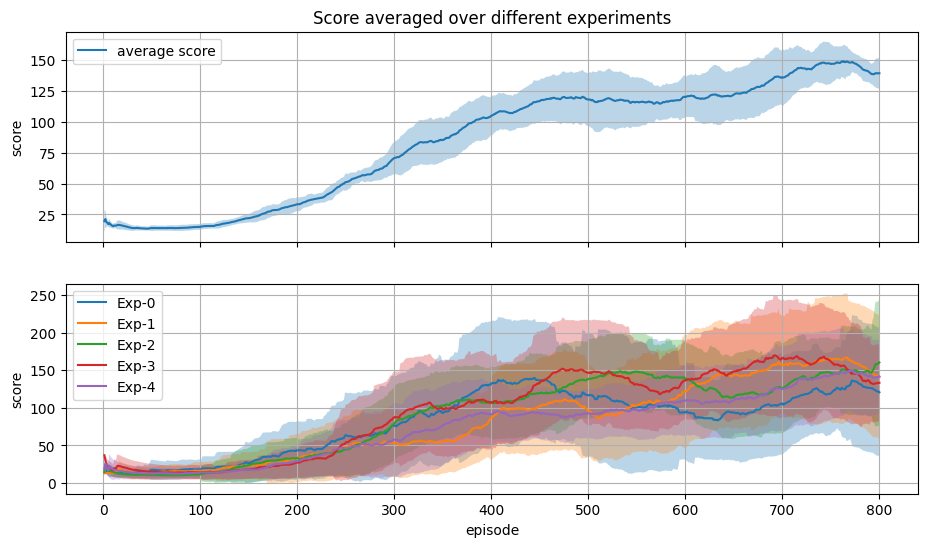

In [12]:
plot_results(avg_scores, std_scores)
results_data_dict["SARSA - with buffer (Batch size = 1)"] = [avg_scores, std_scores]

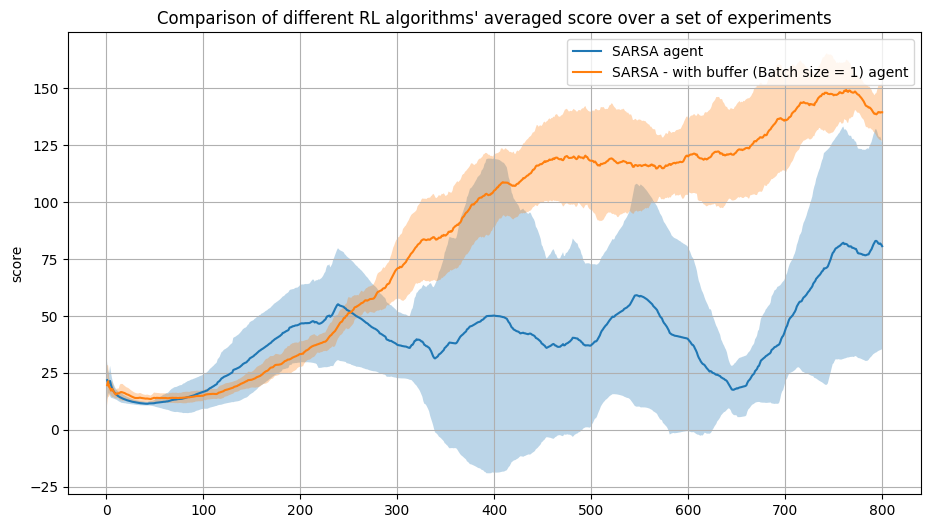

In [13]:
compare_results(results_data_dict)

We see that SARSA with a replay-buffer results in a set of much better learning curves and much lower variance than the original SARSA implementation. This is due to the decorrelation of consecutive learning steps in the agent's experience. We sample transitions from the replay-buffer randomly (using a uniform distribution), so the chance of following batches being correlated to one another inversely depends on the size of the replay-buffer's memory size, which is large, so the chance is small. The decorrelation of training samples is known to improve training processes in neural networks, and that is the case also here.

Finally, we run a few experiments with larger batch size (`BATCH_SIZE = 8`) and fewer episodes (`N_EPISODES = 100`), which ends up with approximately the same number of learning steps for the agent (around $8000$ learning steps) as before. We would like to find what is better, small batches with more episodes or, fewer episodes with larger batches.

In [15]:
env = gym.make('CartPole-v1')
scores = []
avg_scores = []
std_scores = []

N_EXPERIMENTS = 5
N_EPISODES = 100
MAX_STEPS = 500
GAMMA = 0.99
LR = 5e-4
MEMORY_SIZE = 100000
BATCH_SIZE = 8
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1



for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])

    agent = SarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS,
                                 learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                                 epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        action, _ = agent.choose_action(observation)
        score = 0
        step = 0
        done = False

        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action, _ = agent.choose_action(next_observation)
            score += reward
            
            # store transition in buffer
            agent.store_transition(observation, action, reward, next_observation, next_action, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            action = next_action
            step += 1
            
            # check for termination
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f} |' + 
              f' Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: 33.000 | Avg score: 33.000 |
| Experiment:    1 | Episode:    1 | Score: 8.000 | Avg score: 20.500 |
| Experiment:    1 | Episode:    2 | Score: 9.000 | Avg score: 16.670 |
| Experiment:    1 | Episode:    3 | Score: 9.000 | Avg score: 14.750 |
| Experiment:    1 | Episode:    4 | Score: 10.000 | Avg score: 13.800 |
| Experiment:    1 | Episode:    5 | Score: 14.000 | Avg score: 13.830 |
| Experiment:    1 | Episode:    6 | Score: 21.000 | Avg score: 14.860 |
| Experiment:    1 | Episode:    7 | Score: 10.000 | Avg score: 14.250 |
| Experiment:    1 | Episode:    8 | Score: 19.000 | Avg score: 14.780 |
| Experiment:    1 | Episode:    9 | Score: 29.000 | Avg score: 16.200 |
| Experiment:    1 | Episode:   10 | Score: 27.000 | Avg score: 17.180 |
| Experiment:    1 | Episode:   11 | Score: 13.000 | Avg score: 16.830 |
| Experiment:    1 | Episode:   12 | Score: 10.000 | Avg score: 16.310 |
| Experiment:    1 | Episode:   13 | S

| Experiment:    2 | Episode:   25 | Score: 9.000 | Avg score: 12.190 |
| Experiment:    2 | Episode:   26 | Score: 22.000 | Avg score: 12.560 |
| Experiment:    2 | Episode:   27 | Score: 47.000 | Avg score: 13.790 |
| Experiment:    2 | Episode:   28 | Score: 38.000 | Avg score: 14.620 |
| Experiment:    2 | Episode:   29 | Score: 50.000 | Avg score: 15.800 |
| Experiment:    2 | Episode:   30 | Score: 58.000 | Avg score: 17.160 |
| Experiment:    2 | Episode:   31 | Score: 108.000 | Avg score: 20.000 |
| Experiment:    2 | Episode:   32 | Score: 72.000 | Avg score: 21.580 |
| Experiment:    2 | Episode:   33 | Score: 74.000 | Avg score: 23.120 |
| Experiment:    2 | Episode:   34 | Score: 15.000 | Avg score: 22.890 |
| Experiment:    2 | Episode:   35 | Score: 67.000 | Avg score: 24.110 |
| Experiment:    2 | Episode:   36 | Score: 62.000 | Avg score: 25.140 |
| Experiment:    2 | Episode:   37 | Score: 42.000 | Avg score: 25.580 |
| Experiment:    2 | Episode:   38 | Score: 45.000 

| Experiment:    3 | Episode:   46 | Score: 23.000 | Avg score: 20.450 |
| Experiment:    3 | Episode:   47 | Score: 10.000 | Avg score: 20.230 |
| Experiment:    3 | Episode:   48 | Score: 20.000 | Avg score: 20.220 |
| Experiment:    3 | Episode:   49 | Score: 15.000 | Avg score: 20.120 |
| Experiment:    3 | Episode:   50 | Score: 28.000 | Avg score: 20.270 |
| Experiment:    3 | Episode:   51 | Score: 9.000 | Avg score: 20.060 |
| Experiment:    3 | Episode:   52 | Score: 31.000 | Avg score: 20.260 |
| Experiment:    3 | Episode:   53 | Score: 43.000 | Avg score: 20.690 |
| Experiment:    3 | Episode:   54 | Score: 17.000 | Avg score: 20.620 |
| Experiment:    3 | Episode:   55 | Score: 37.000 | Avg score: 20.910 |
| Experiment:    3 | Episode:   56 | Score: 10.000 | Avg score: 20.720 |
| Experiment:    3 | Episode:   57 | Score: 10.000 | Avg score: 20.530 |
| Experiment:    3 | Episode:   58 | Score: 9.000 | Avg score: 20.340 |
| Experiment:    3 | Episode:   59 | Score: 11.000 | 

| Experiment:    4 | Episode:   58 | Score: 275.000 | Avg score: 52.530 |
| Experiment:    4 | Episode:   59 | Score: 46.000 | Avg score: 52.420 |
| Experiment:    4 | Episode:   60 | Score: 43.000 | Avg score: 52.260 |
| Experiment:    4 | Episode:   61 | Score: 82.000 | Avg score: 52.740 |
| Experiment:    4 | Episode:   62 | Score: 74.000 | Avg score: 53.080 |
| Experiment:    4 | Episode:   63 | Score: 125.000 | Avg score: 54.200 |
| Experiment:    4 | Episode:   64 | Score: 101.000 | Avg score: 54.920 |
| Experiment:    4 | Episode:   65 | Score: 87.000 | Avg score: 55.410 |
| Experiment:    4 | Episode:   66 | Score: 100.000 | Avg score: 56.070 |
| Experiment:    4 | Episode:   67 | Score: 97.000 | Avg score: 56.680 |
| Experiment:    4 | Episode:   68 | Score: 194.000 | Avg score: 58.670 |
| Experiment:    4 | Episode:   69 | Score: 123.000 | Avg score: 59.590 |
| Experiment:    4 | Episode:   70 | Score: 161.000 | Avg score: 61.010 |
| Experiment:    4 | Episode:   71 | Score: 

| Experiment:    5 | Episode:   71 | Score: 112.000 | Avg score: 89.430 |
| Experiment:    5 | Episode:   72 | Score: 198.000 | Avg score: 90.920 |
| Experiment:    5 | Episode:   73 | Score: 196.000 | Avg score: 92.340 |
| Experiment:    5 | Episode:   74 | Score: 244.000 | Avg score: 94.360 |
| Experiment:    5 | Episode:   75 | Score: 243.000 | Avg score: 96.320 |
| Experiment:    5 | Episode:   76 | Score: 181.000 | Avg score: 97.420 |
| Experiment:    5 | Episode:   77 | Score: 149.000 | Avg score: 98.080 |
| Experiment:    5 | Episode:   78 | Score: 113.000 | Avg score: 98.270 |
| Experiment:    5 | Episode:   79 | Score: 211.000 | Avg score: 99.680 |
| Experiment:    5 | Episode:   80 | Score: 201.000 | Avg score: 100.930 |
| Experiment:    5 | Episode:   81 | Score: 144.000 | Avg score: 101.450 |
| Experiment:    5 | Episode:   82 | Score: 161.000 | Avg score: 102.170 |
| Experiment:    5 | Episode:   83 | Score: 255.000 | Avg score: 103.990 |
| Experiment:    5 | Episode:   84

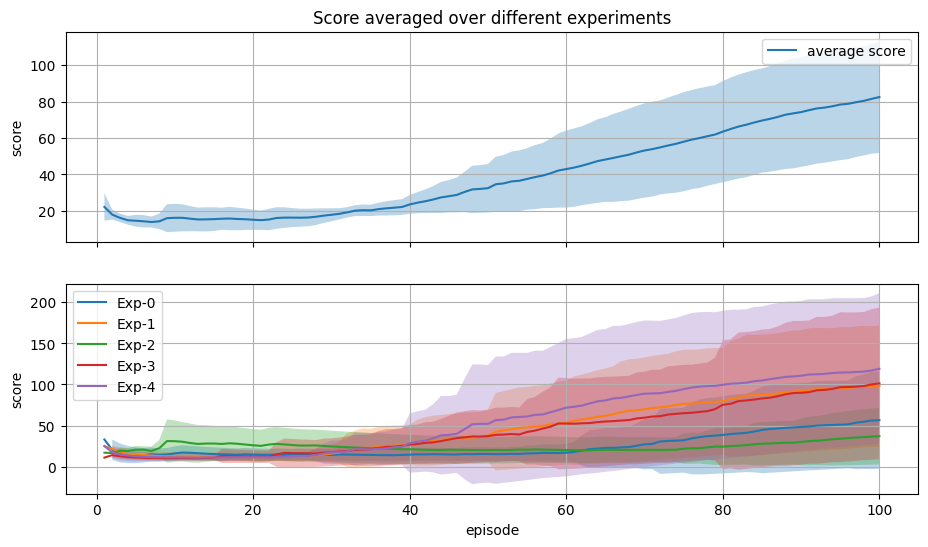

In [16]:
plot_results(avg_scores, std_scores)
results_data_dict["SARSA - with buffer (Batch size = 8)"] = [avg_scores, std_scores]

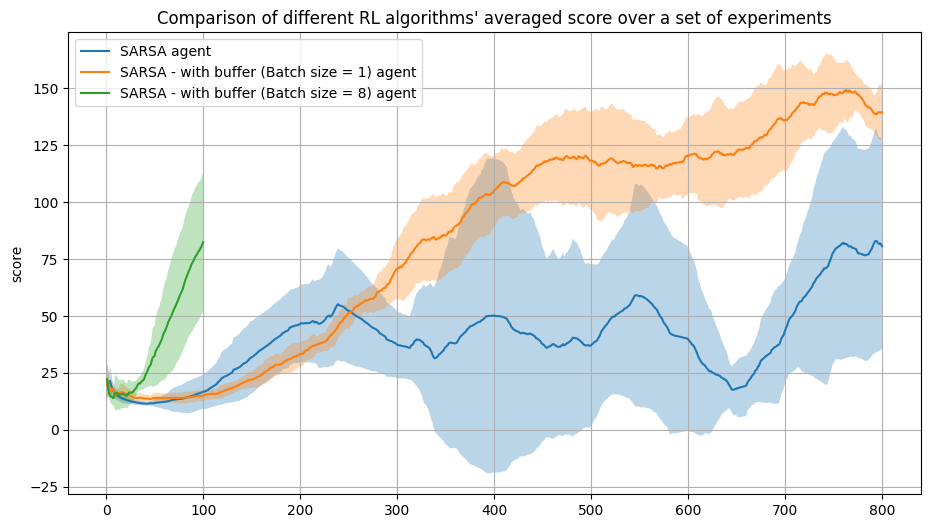

In [17]:
compare_results(results_data_dict)

It seems from the comparison plot above that more episodes with smaller batches bits fewer episodes with larger batches, and both bits an agent without a replay-buffer at all. Nevertheless, the `BATCH_SIZE = 8`'s  agent seems to have a *cleaner* learning curve. However, the statistics is not enough in order to have some really meaningful conclusion about the comparison of the two methods.

## Conclusion

We have implemented two variations of the on-polcy RL algorithm SARSA, with and without an experience replay buffer.  The experience replay buffer addition to the algorithms clearly improves a lot the learning process in terms of stability, repeatability (between experiments), lower variance, and quicker learning. These are mostly due to the decorrelation of transitions used in the learning process, which arises when using a buffer (we sample transitions randomly from the buffer, which for large buffers results in uncorrelated batches of transitions). 

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)
- [2] Long-Ji Lin - Self-Improving Reactive Agents Based On Reinforcement Learning, Planning and Teaching (1992)
- [3] Shangtong Zhang, Richard S. Sutton - A Deeper Look at Experience Replay (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com